# Analysis of Six Squad's Sales and Global Sneaker Store Reviews

## We have two main datasets from which we are attempting to extract insights  using Unsupervised Machine Learning technniques

* ###  `Transaction Data` from Six Squad, a Kazakhstani Sneaker and Apparel Brand
* ### `Text Reviews` of the top Sneaker Stores in NYC, London and Tokyo, scraped from Google Maps   

## Objective: To combine the company-specific insights, derived from analysing transaction data, with the global trends and insights, extracted from top sneaker store reviews, to present Six Squad with comprehensive recommendations for business development.



## **Table of Contents**
1. ###  **Transaction Data Analysis**
#### a. Data Extraction
#### b. Data Preprocessing
#### c. Exploratory Data Analysis
#### d. Market Basket Analysis
#### e. Clustering
2. ### **Review Data Analysis**
#### a. Data Preprocessing
#### b. Exploratory Data Analysis
#### c. Word Cloud
#### d. Distribution of Sentiment Polarity
#### e. Topic Modelling (LDA)
#### f. Aspect-based Sentiment Analysis (ASBA)

# Transaction Data Analysis

## In this section, we will apply unsupervised ML methods to uncover trends and insights in Six Squad's transaction data. We will begin with basic EDA, before moving on to more advanced methods - Market Basket Analysis for product-related insights and Clustering for customer-related insights.  


## Data Extraction
We wrote this SQL query below:
```
SELECT A.[ЧекККМ ID] AS CheckID
	  ,A.[ЧекККМ Дата] AS DateAndTime
	  ,A.[ЧекККМ Склад ID] AS StoreID
	  ,REPLACE(C.[Склады Наименование],'Склад','Store') AS StoreName
	  ,A.[ЧекККМ Партнер ID] AS CustomerID
	  ,REPLACE(D.[Партнеры Наименование],'Розничный покупатель','Buyer') AS CustomerName
	  ,D.[Партнеры Дата Регистрации] AS CustomerRegDate
	  ,D.[Партнеры Дата Рождения] AS CustomerBirthDate
	  ,B.[ЧекККМ.Товары Номенклатура ID] AS ProductID
	  ,REPLACE(E.[Номенклатура Наименование],',','/') AS ProductName  --REPLACING COMMAS TO AVOID ERRORS IN CSV FILE
      ,E.[Номенклатура Артикул] AS ProductArticle
	  ,B.[ЧекККМ.Товары Характеристика ID] AS CharacteristicID
	  ,REPLACE(F.[ХарактеристикиНоменклатуры Наименование],',','.') AS Size --REPLACING COMMAS TO AVOID ERRORS IN CSV FILE
	  ,B.[ЧекККМ.Товары Количество] AS Quantity
      ,B.[ЧекККМ.Товары Цена] AS Price
	  ,B.[ЧекККМ.Товары Сумма Автоматической Скидки] + B.[ЧекККМ.Товары Сумма Ручной Скидки] AS Discount
	  ,B.[ЧекККМ.Товары Сумма] AS Summ
FROM [_six_squad_ut].[dbo].[Документы.ЧекККМ] AS A
LEFT JOIN [_six_squad_ut].[dbo].[Документы.ЧекККМ.Товары] AS B
ON A.[ЧекККМ ID] = B.[ЧекККМ ID]
LEFT JOIN [_six_squad_ut].[dbo].[Справочники.Склады] AS C
ON A.[ЧекККМ Склад ID] = C.[Склады ID]
LEFT JOIN [_six_squad_ut].[dbo].[Справочники.Партнеры] AS D
ON A.[ЧекККМ Партнер ID] = D.[Партнеры ID]
LEFT JOIN [_six_squad_ut].[dbo].[Справочники.Номенклатура] AS E
ON B.[ЧекККМ.Товары Номенклатура ID] = E.[Номенклатура ID]
LEFT JOIN [_six_squad_ut].[dbo].[Справочники.ХарактеристикиНоменклатуры] AS F
ON B.[ЧекККМ.Товары Характеристика ID] = F.[ХарактеристикиНоменклатуры ID]
WHERE F.[ХарактеристикиНоменклатуры Наименование] <> 'Тест' --FILTERING OUT TEST TRANSACTIONS
ORDER BY A.[ЧекККМ Дата]
```

The data is stored in the local Microsoft SQL Server of Six Squad, a private Kazakhstan apparel company. We used the above query to extract the required data.

1.   We had to JOIN 6 Tables labeled as A (Transaction Data), B (Products within transaction), C (Location Data), D (Customer Data), E (Product Nomenclature Data), and F (Product Characteristics Data).
2.   Each Table had redundant and unnecessary columns, which were filtered out by the SELECT query by specifying the fields needed in one big Dataframe.
3.	Every table name, columns, and some rows, were in Russian. We renamed them using Aliases (AS). We also used the REPLACE function to replace commas to avoid errors when exporting to CSV format.
4.	We Filtered out the 'Test' datapoints using the WHERE function as they are not real transactions.
5.	We ordered the table using the ORDER BY function so that it will be in the correct chronological order.




| Column    | Description                                       | Dtype |
|-----------|---------------------------------------------------|-------|
| `CheckID`| Transaction ID| string|
| `DateAndTime`| Date and time Transaction occured| date|
| `StoreID` | Store Location ID| string|
| `StoreName`| Store Location Name | string|
| `CustomerID`| Customer ID | string|
| `CustomerName`| Customer Name  | string|
| `CustomerRegDate`| Customer Date of Registration | date|
| `CustomerBirthDate` | Customer Birth Day| date |
|`ProductID`| Product ID | string|
|`ProductName`| Product Name | string|
|`ProductArticle`| Product Article | string|
|`CharacteristicID`| Product's Characteristic ID | string|
|`Size`| Product Size | string|
|`Quantity`| Quantity of product purchased | int|
|`Price`| Retail Price of purchased Product | int|
|`Discount`| Discount amount on the product | float64|
|`Summ`| Quantity * (Price - Discount) | float64|


## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Read store data
df_transactions = pd.read_csv('https://raw.githubusercontent.com/d-roho/BA820-TeamA6/main/Data%20files/Master%20Transactions%20Table.csv?token=GHSAT0AAAAAACNGGZA3SRVNG27IHQKHGI36ZPFE5BA', delimiter= ';')
df_articles = pd.read_csv('https://raw.githubusercontent.com/d-roho/BA820-TeamA6/main/Data%20files/Product%20Article%20Details%20-%20Sheet1.csv?token=GHSAT0AAAAAACNGGZA3VWLXECJ5OQOQ4KL6ZPFE5FQ', delimiter= ',')

# Replace Russian product names with English
dict_articles = df_articles.set_index('Product ID')['Product Name'].to_dict()
df_transactions['ProductNameNew'] = df_transactions['ProductArticle'].map(dict_articles)
df_transactions['ProductNameNew'].fillna('nan', inplace=True)

for i,r in df_transactions.iterrows():
    if df_transactions.loc[i, 'ProductNameNew'] != 'nan':
        df_transactions.loc[i, 'ProductName'] = df_transactions.loc[i, 'ProductNameNew']
df_transactions.drop('ProductNameNew', axis=1, inplace=True)

# Display DF
df_transactions.head()


,CheckID,DateAndTime,StoreID,StoreName,CustomerID,CustomerName,CustomerRegDate,CustomerBirthDate,ProductID,ProductName,ProductArticle,CharacteristicID,Size,Quantity,Price,Discount,Summ
0,963700505601437611ED79E88B2ADAF1,2022-12-12 09:51:58,963700505601437611ED75F098F0D0F2,Store FORUM,913408979892110F11ED60BAE5B67FDC,Buyer,1980-01-01 00:00:00,2001-01-01 00:00:00,963700505601437611ED76D571C900D0,Bomber Jacket Iconic Players -,FT0015,963700505601437611ED76D5CC8A6730,2XL,1.0,83000.0,0.0,83000.0
1,963700505601437611ED7DC11AB805C7,2022-12-17 07:13:28,963700505601437611ED75F098F0D0F2,Store FORUM,913408979892110F11ED60BAE5B67FDC,Buyer,1980-01-01 00:00:00,2001-01-01 00:00:00,963700505601437611ED7ADAA5BDD6DE,NOCTA Hot Step Air Terra,DH4692-002,963700505601437611ED7AE596BCE2F7,9.5,1.0,138000.0,8280.0,129720.0
2,963700505601437611ED7DC11AB805C7,2022-12-17 07:13:28,963700505601437611ED75F098F0D0F2,Store FORUM,913408979892110F11ED60BAE5B67FDC,Buyer,1980-01-01 00:00:00,2001-01-01 00:00:00,963700505601437611ED7ADDC672C19A,M NRG NOCTA SS TOP,DM1724-010,963700505601437611ED7AE5AB1C1750,L,1.0,39000.0,2340.0,36660.0
3,963700505601437611ED7DC11AB805C9,2022-12-17 11:34:15,963700505601437611ED75F098F0D0F2,Store FORUM,913408979892110F11ED60BAE5B67FDC,Buyer,1980-01-01 00:00:00,2001-01-01 00:00:00,963700505601437611ED75485EA48889,FRA JD FFBB LOGO SS,CV8138-419,963700505601437611ED755A89273B56,XL,1.0,29000.0,0.0,29000.0
4,963700505601437611ED7DC11AB805CB,2022-12-17 12:59:23,963700505601437611ED75F098F0D0F2,Store FORUM,913408979892110F11ED60BAE5B67FDC,Buyer,1980-01-01 00:00:00,2001-01-01 00:00:00,963700505601437611ED755791B0DF6C,M J JUMPMAN SS CREW,CJ0921-011,963700505601437611ED755A89273B67,S,1.0,18000.0,0.0,18000.0


**Preprocessing Step** - We convert Russian product names to english by using Product Articles data (df_articles) to replace the transactions' product names with official english names using ProductID.

In [ ]:
df_transactions.describe()

,Quantity,Price,Discount,Summ
count,7002.000000,7002.000000,7002.000000,7002.000000
mean,1.015139,63306.588832,3289.081348,60039.157908
std,0.165774,49368.265795,10015.252213,48074.184529
min,1.000000,6500.000000,0.000000,3885.750000
25%,1.000000,24200.000000,0.000000,22500.000000
50%,1.000000,51000.000000,0.000000,46000.000000
75%,1.000000,97000.000000,0.000000,94000.000000
max,6.000000,745000.000000,149000.000000,649000.000000


* The table above shows that there are 7002 transactions in total
* Average Quantity is approximately 1 (on average, only a single quantity of each product present in a a given transaction is purchased)
* Average price of around 63306 KZT (140 USD)
* Average discount of about 3289 KZT (7 USD)
* Average sum (price after discount) of approximately 60,039 KZT (133 USD).

**NOTE: KZT stands for Kazakhstani Tenge (local currency) -> 1 USD = 450 KZT**

In [ ]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7002 entries, 0 to 7001
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CheckID            7002 non-null   object 
 1   DateAndTime        7002 non-null   object 
 2   StoreID            7002 non-null   object 
 3   StoreName          7002 non-null   object 
 4   CustomerID         7002 non-null   object 
 5   CustomerName       7002 non-null   object 
 6   CustomerRegDate    7002 non-null   object 
 7   CustomerBirthDate  7002 non-null   object 
 8   ProductID          7002 non-null   object 
 9   ProductName        7002 non-null   object 
 10  ProductArticle     7002 non-null   object 
 11  CharacteristicID   7002 non-null   object 
 12  Size               7002 non-null   object 
 13  Quantity           7002 non-null   float64
 14  Price              7002 non-null   float64
 15  Discount           7002 non-null   float64
 16  Summ               7002 

The columns contain different types of information: some are strings (like CustomerName and IDs), while others are numbers (Price and Quantity). Each column has 7002 pieces of information, showing that none of them are empty or missing in the dataframe.

### Lets merge transactions data with product article data


In [2]:
df_product = df_articles.loc[:]
df_product.head()

,#,Product ID,Product Name,Image URL,Gender,Brand,Category,Color,Collaboration,Weights in kg,Dimensions,Sneakers Model,Season
0,1,DC3673-011,JORDAN H86 JM WASHED CAP,https://shelta.eu/pub_images/large/DC3673-011_...,Unisex,Jordan,Caps,Black,False,"0,1",10x5x2,NaN,Summer
1,2,DM5231-040,W J HERITAGE BOTTOM,https://static.insales-cdn.com/images/products...,Women,Jordan,Trousers,Multicolor,False,"0,2",10x10x10,NaN,Summer
2,3,CJ0921-011,M J JUMPMAN SS CREW,https://static.insales-cdn.com/images/products...,Men,Jordan,T-shirts,Black,False,"0,5",20x15x3,NaN,Summer
3,4,DH0833-660,Air Jordan XXXVI Low,https://static.insales-cdn.com/images/products...,Men,Jordan,Sneakers,Red,False,"0,5",25x15x10,Air Jordan XXXVI,Demi-season
4,5,CJ0921-687,M J JUMPMAN SS CREW,https://static.insales-cdn.com/images/products...,Men,Jordan,T-shirts,Red,False,"0,5",20x15x3,NaN,Summer


This dataframe contains more specific information on product category, color, collaboration status etc.. We will merge it with the transactions table so we have all relevant info in one dataframe.

In [3]:
merged_df = pd.merge(df_transactions, df_product, left_on='ProductArticle', right_on='Product ID', how='left')
merged_df.head()

,CheckID,DateAndTime,StoreID,StoreName,CustomerID,CustomerName,CustomerRegDate,CustomerBirthDate,ProductID,ProductName,...,Image URL,Gender,Brand,Category,Color,Collaboration,Weights in kg,Dimensions,Sneakers Model,Season
0,963700505601437611ED79E88B2ADAF1,2022-12-12 09:51:58,963700505601437611ED75F098F0D0F2,Store FORUM,913408979892110F11ED60BAE5B67FDC,Buyer,1980-01-01 00:00:00,2001-01-01 00:00:00,963700505601437611ED76D571C900D0,Bomber Jacket Iconic Players -,...,https://static.insales-cdn.com/images/products...,Men,Football Town,Bombers,Black,False,"0,1",2x2x2,NaN,Demi-season
1,963700505601437611ED7DC11AB805C7,2022-12-17 07:13:28,963700505601437611ED75F098F0D0F2,Store FORUM,913408979892110F11ED60BAE5B67FDC,Buyer,1980-01-01 00:00:00,2001-01-01 00:00:00,963700505601437611ED7ADAA5BDD6DE,NOCTA Hot Step Air Terra,...,https://static.insales-cdn.com/images/products...,Men,Nike,Sneakers,Black,True,"0,5",25x15x10,NaN,Demi-season
2,963700505601437611ED7DC11AB805C7,2022-12-17 07:13:28,963700505601437611ED75F098F0D0F2,Store FORUM,913408979892110F11ED60BAE5B67FDC,Buyer,1980-01-01 00:00:00,2001-01-01 00:00:00,963700505601437611ED7ADDC672C19A,M NRG NOCTA SS TOP,...,https://static.insales-cdn.com/images/products...,Men,Nike,T-shirts,Black,True,"0,5",20x15x3,NaN,Summer
3,963700505601437611ED7DC11AB805C9,2022-12-17 11:34:15,963700505601437611ED75F098F0D0F2,Store FORUM,913408979892110F11ED60BAE5B67FDC,Buyer,1980-01-01 00:00:00,2001-01-01 00:00:00,963700505601437611ED75485EA48889,FRA JD FFBB LOGO SS,...,https://static.insales-cdn.com/images/products...,Men,Jordan,T-shirts,Blue,False,"0,5",20x15x3,NaN,Summer
4,963700505601437611ED7DC11AB805CB,2022-12-17 12:59:23,963700505601437611ED75F098F0D0F2,Store FORUM,913408979892110F11ED60BAE5B67FDC,Buyer,1980-01-01 00:00:00,2001-01-01 00:00:00,963700505601437611ED755791B0DF6C,M J JUMPMAN SS CREW,...,https://static.insales-cdn.com/images/products...,Men,Jordan,T-shirts,Black,False,"0,5",20x15x3,NaN,Summer


In [5]:
# Converting DateAndTime to datetime
from datetime import datetime
merged_df['DateAndTime'] = pd.to_datetime(merged_df['DateAndTime'])
merged_df['date_column'] = merged_df['DateAndTime'].dt.date

## Exploratory Data Analysis


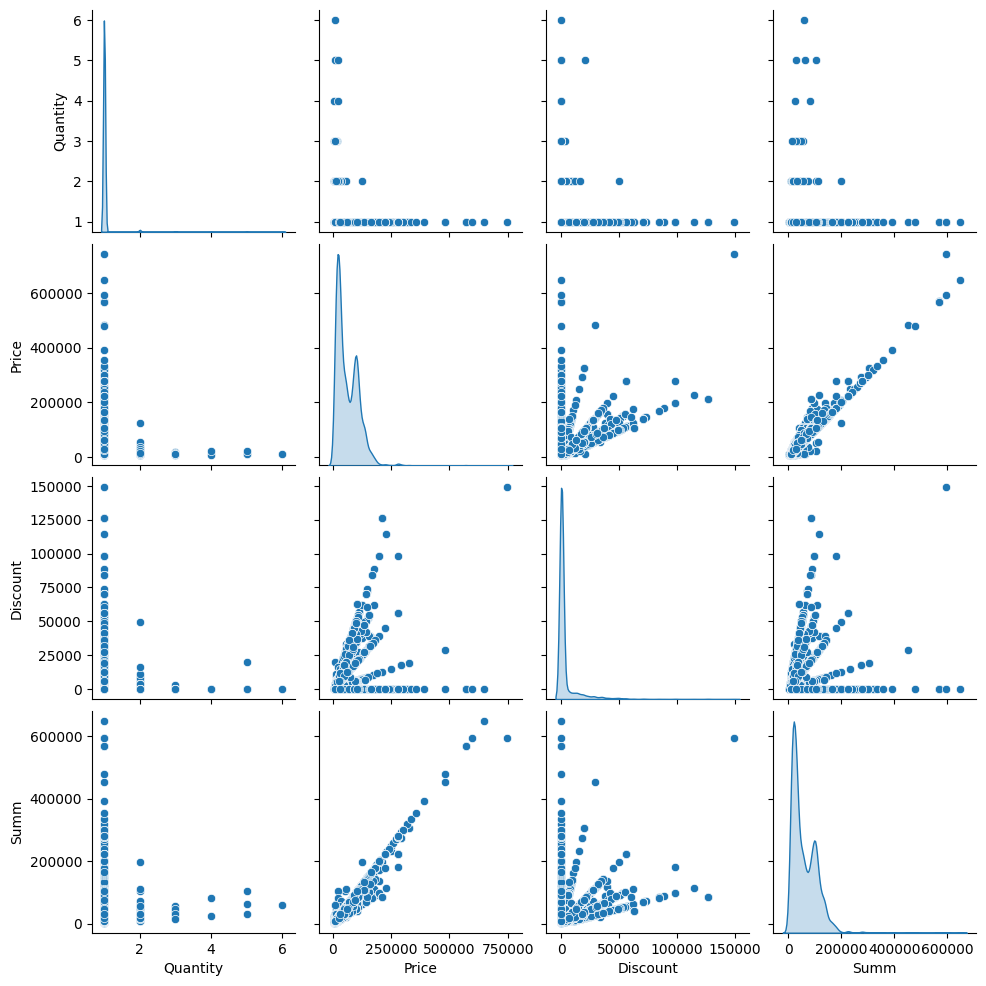

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_transactions, diag_kind = 'kde')
plt.show();

This pairplot shows the correlation between different variables (e.g., Quantity, Price, Discount, Summ). Red cells indicate positive correlation, while blue cells represent negative correlation. The diagonal cells are perfectly correlated (red). For instance, Price and Summ have a strong positive correlation. Since this chart does not give us any significant results lets proceed to plotting other visuals.

We can also see the distribution of the numeric variables

*   Quantity - vast majority of quantities is 1 indicating majority of people purchase only 1 of each product. This is because these are high-priced products purchased in limited quantities.
*   Price - it is bimodal, representing two main categories of products - premium (moderate cost) & luxury (high cost)
*   Discount - A majority of values are close to zero. This is due to the fact that most product are never discounted.
*   Sum - Again, it is bimodal, reflecting the distribution of Price (as Summ is price * quantity)




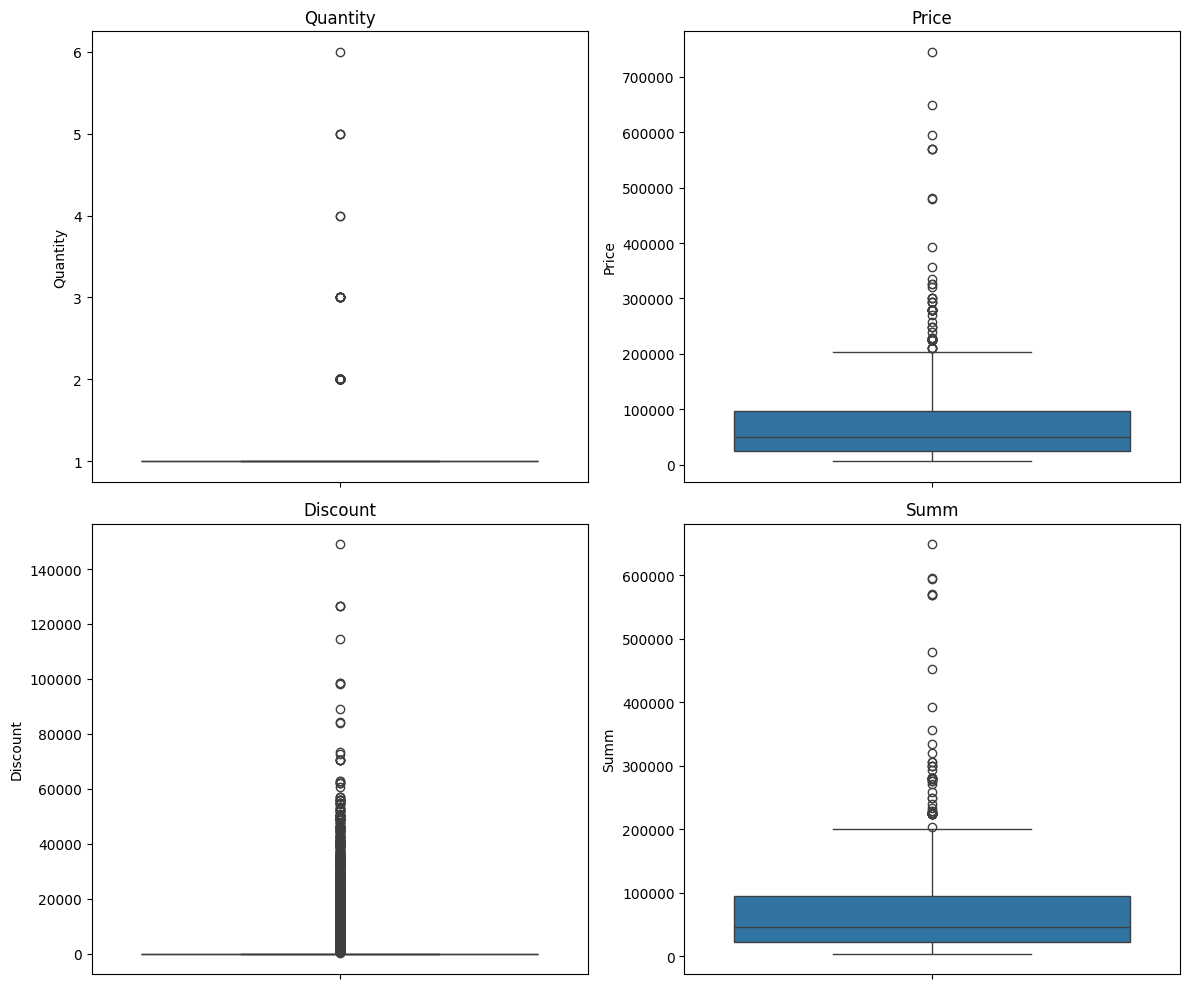

In [ ]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Box plot for Quantity
sns.boxplot(y=df_transactions['Quantity'], ax=axes[0, 0])
axes[0, 0].set_title('Quantity')

# Box plot for Price
sns.boxplot(y=df_transactions['Price'], ax=axes[0, 1])
axes[0, 1].set_title('Price')

# Box plot for Discount
sns.boxplot(y=df_transactions['Discount'], ax=axes[1, 0])
axes[1, 0].set_title('Discount')

# Box plot for Summ
sns.boxplot(y=df_transactions['Summ'], ax=axes[1, 1])
axes[1, 1].set_title('Summ')

# Adjust layout
plt.tight_layout()
plt.show()

There are a significant number of outliers for Price, Summ and Discount

* Price and Summ - Outliers are luxury items sold at extremely high prices. For example, S'YTE x Junji Ito UZUMAKI 1000% Bearbrick which is sold for Retail Price of 1600 USD
* Discount - Since most producs are never discounted, all the outliers are discounts greater than zero.
* Quantity - Most items are purchases in single quantity, as previously mentioned. Any greater quantities are outliers compared to the majoritty of the dataset.

Since these outliers reflect the reality of the business, and are not mistakes or noise, we will keep them for further analysis.

Text(0, 0.5, 'Total Transactions')

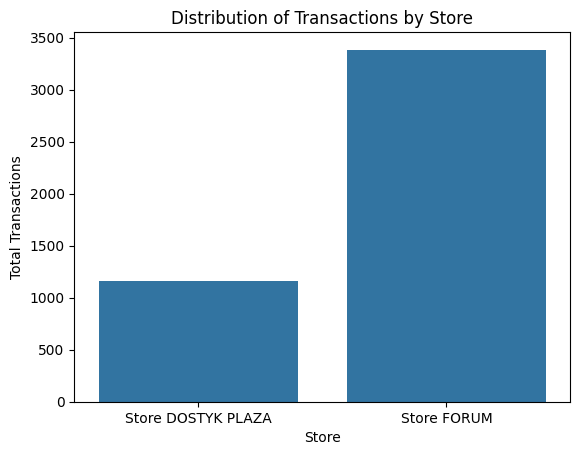

In [ ]:
# Transaction by store
store_transactions = df_transactions.groupby('StoreName').agg({"CheckID": pd.Series.nunique}).reset_index()
sns.barplot(x='StoreName', y='CheckID', data=store_transactions )
plt.title('Distribution of Transactions by Store')
plt.xlabel('Store')
plt.ylabel('Total Transactions')

Six Squad has two stores, FORUM (the first store launched about December 2022) and DOSTYK PLAZA (the second store launched about December 2023). Hence, FORUM has about 3x the number of transactions as DOSTYK PLAZA. It is to be noted that the new store is growing at a faster rate than the old store, when accounting for the time each store has been opened for.


In [6]:
# Calculating total sales by Date and Store
df_plot_1 = merged_df.groupby('date_column').agg({'Quantity': 'sum', 'StoreName': 'first', 'Summ': 'sum'})

df_plot_1.head()

,Quantity,StoreName,Summ
date_column,,,
2022-12-12,1.0,Store FORUM,83000.0
2022-12-17,13.0,Store FORUM,919020.0
2022-12-18,13.0,Store FORUM,1160880.0
2022-12-19,15.0,Store FORUM,989000.0
2022-12-20,18.0,Store FORUM,1529000.0


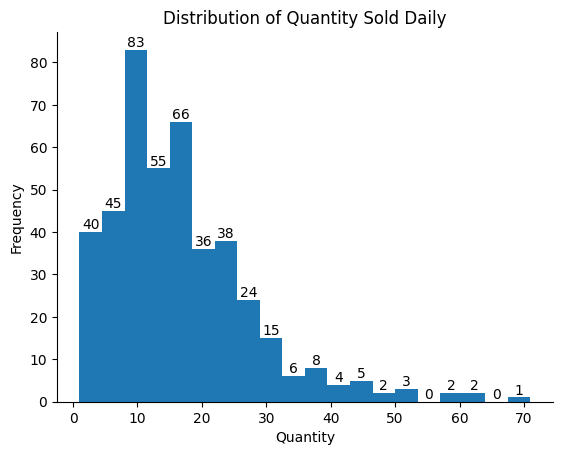

Mean Quantity sold daily = 16.34022988505747


In [ ]:
from matplotlib import pyplot as plt

ax = df_plot_1['Quantity'].plot(kind='hist', bins=20, title='Distribution of Quantity Sold Daily')

for rect in ax.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height, f'{int(height)}', ha='center', va='bottom')

plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(False)
plt.show()

print(f"Mean Quantity sold daily = {df_plot_1['Quantity'].mean()}")

**Here we have a distribution of the quantity of items sold daily. Approx. 16 items are sold daily across both stores.**

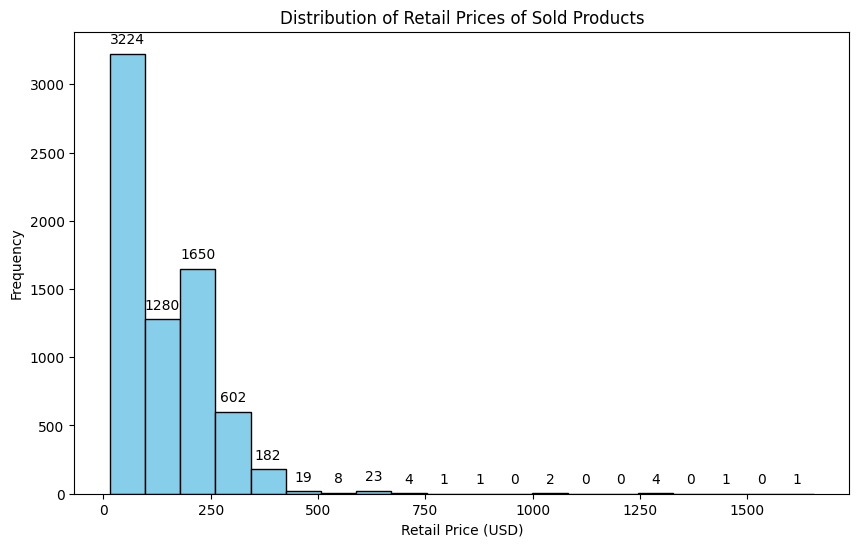

Mean Retail price of products sold = 140.68130851502747 USD


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_transactions['Price']/450, bins=20, color='skyblue', edgecolor='black')

for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().annotate(f'{height:.0f}',
                       (rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 5),
                       textcoords='offset points',
                       ha='center',
                       va='bottom')

plt.title('Distribution of Retail Prices of Sold Products')
plt.xlabel('Retail Price (USD)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()
print(f"Mean Retail price of products sold = {df_transactions['Price'].mean()/450} USD")

**We can see that the average price of products is approx. 140 USD, with some outliers exceeding the 500 USD mark.**

In [7]:
df_plot_1=df_plot_1.reset_index()
df_plot_1['date_column'] = pd.to_datetime(df_plot_1['date_column'])

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

start_date = pd.to_datetime('2023-12-01')

df_plot_1_filtered = df_plot_1[df_plot_1['date_column'] >= start_date]

df_plot_1_filtered['weekend'] = df_plot_1_filtered['date_column'].dt.dayofweek >= 5

fig = make_subplots(specs=[[{"secondary_y": True}]])

for store in df_plot_1_filtered['StoreName'].unique():
    store_data = df_plot_1_filtered[df_plot_1_filtered['StoreName'] == store]
    fig.add_trace(go.Scatter(x=store_data['date_column'], y=store_data['Summ']/450,
                             mode='lines', name=store),
                  secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_1_filtered['date_column'], y=df_plot_1_filtered['weekend'],
                         fill='tonexty', fillcolor='rgba(99, 110, 250, 0.2)',
                         line_shape='hv', line_color='rgba(0,0,0,0)',
                         name='Weekend Days'),
              secondary_y=True)

fig.update_layout(
    title="Daily Net Sales with Weekends Highlighted",
    xaxis_title="Date",
    yaxis_title="Net Sales (USD)",
    hovermode="x",
)

fig.show()


**There is a consistent and significant uptick in Net Sales over the weekends across both stores. The average daily net sales is approx. 2150 USD**

## Market Basket Analysis

### In this Section, our objectives are in identifying the most commonly purchased items by our customers and uncovering association rules. Furthermore, we aim to explore the variation in customer behavior between weekdays and weekends. Lastly, we seek to understand how our product categories connect, allowing us to check customer preferences and whether they like towards outfit purchases or individual items.

### Our chosen methodology to use the MLxtend library, specifically applying the Apriori algorithm to extract frequent itemsets and association rules. Through this approach, we aim to derive insightful analyses that investigate customer preferences and shopping patterns,

In [36]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [ ]:
merged_df['CheckID'].value_counts()

CheckID
A2BEA83E4941C7C411EDF1A6153559D6    19
A3E18B555238DE9911EDECE698CC337A    18
B6A9F3D42C1B20B211EE6B46F8A25E0D    14
B6E1D93CB721767C11EE976741D2E752    12
B6E7EB4FF2EF782011EE9C047F2CA510    11
                                    ..
80EAAC2FC0CA8E7811EE1753EC2E0D10     1
80EB95558271282511EE17E1B9C55E33     1
80EB95558271282511EE17E2F0901DD4     1
80EB95558271282511EE17ED63F3C374     1
B72DA8CC849C518A11EED32C318E8C4F     1
Name: count, Length: 4545, dtype: int64

In [ ]:
transaction_list = merged_df.groupby('CheckID')['ProductName'].agg(list)
transaction_list

CheckID
80CDF2721D3090D211EE003F65A567E4                                    [W NIKE DUNK LOW]
80CDF2721D3090D211EE0065DF800E65    [Kevin Durant Nets_BLACK/FLT SILVER/DURANT KEVIN]
80CDF2721D3090D211EE006AE64EF24D    [Nike Court Vision LO_WHITE/ATMOSPHERE-UNIVERS...
80CDF2721D3090D211EE007218CCAD17            [Jordan Everyday Max_BLACK/WHITE/GYM RED]
80CDF2721D3090D211EE00731A2E0927                                 [WMNS NIKE DUNK LOW]
                                                          ...                        
B72DA8CC849C518A11EED315877887E6                                     [The Bird Black]
B72DA8CC849C518A11EED319C3033CE6    [Jordan Artist Series by Jacob Rochester_RATTA...
B72DA8CC849C518A11EED31A364D3309                              [WMNS AIR JORDAN 1 LOW]
B72DA8CC849C518A11EED323DAA8F97C                                 [AIR JORDAN 4 RETRO]
B72DA8CC849C518A11EED32C318E8C4F                         [U NK NRG FEARLESS PHIL TEE]
Name: ProductName, Length: 4545, dtype: object

We have successfully grouped by the transaction and product name and use agg() method to list them. Data is now ready for Endocder process.

In [ ]:
encoder = TransactionEncoder()
transactions_encoded = encoder.fit(transaction_list).transform(transaction_list)

df_encoded = pd.DataFrame(transactions_encoded,columns=encoder.columns_)
df_encoded

,400% & 100% Bearbrick Set - Coca-Cola (Georgia Green),400% & 100% Bearbrick Set - Jerry Classic Color (Tom & Jerry),400% & 100% Bearbrick Set - Keith Haring v9 (Dancing Dogs),400% & 100% Bearbrick Set - Michelangelo Chrome (Teenage Mutant Ninja Turtles),400% & 100% Bearbrick Set - Mr. Incredible (Walt Disney),400% & 100% Bearbrick Set - Robin (The New Batman Adventures),400% & 100% Bearbrick Set - The Rolling Stones (Hot Lips logo - Black Chrome),400% & 100% Bearbrick set - ''The 53 Stations'' (Utagawa Kuniyoshi),400% & 100% Bearbrick set - Doubly Warped Black Hole (NASA),400% & 100% Bearbrick set - Girl with a Pearl Earring by Johannes Vermeer,...,Шорты MARKET Fine Cut Reversible,кроссовки AIR FORCE 1 07,кроссовки AJ1 Low CUSTOM YUG,кроссовки NIKE DUNK HI RETRO PRM,кроссовки NIKE DUNK LOW RETRO PRM,кроссовки W NIKE DUNK LOW,кроссовки W NIKE DUNK LOW TWIST,кроссовки WMNS AIR FORCE 1 07 MID,кроссовки WMNS NIKE DUNK LOW,сумка JUMPMAN DUFFLE
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4540,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4541,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4542,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4543,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


As we can see above that we have 1082 products and 4545 transactions that were made. Now our data is ready for Market Basket Analysis

### What are the most frequent itemsets across different stores?

In [ ]:
frequent_itemsets = apriori(df_encoded,min_support=0.0015,use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets
251,0.022662,(WMNS AIR JORDAN 1 LOW)
33,0.020022,(Bearbrick Blindbox series 46 by Medicom Toy)
42,0.019142,"(CR7 Fashion, 2-Pack Trunk Mesh)"
44,0.018482,"(CR7 Trunk, 3-pack)"
227,0.015842,(U J ED CUSH POLY CREW 3PR 144)
...,...,...
159,0.001540,(NIKE AIR MAX PLUS III PRM)
156,0.001540,(NEW YORK YANKEES TEAM COLOUR CORD NAVY 9FIFTY...
153,0.001540,(MN Skate Half Cab '92)
152,0.001540,(M NSW TEE OC PK3 LBR)



*   The threshold of 0.15% was used to filter the itemsets, meaning only those appearing in at least 0.15% ( 7 times been purchased) of all transactions were considered frequent. This helps in focusing the analysis on itemsets with a significant presence and resulted in considering 276 itemsets as frequent.



*   (WMNS AIR JORDAN 1 LOW) with a support of  0.022662% of all transactions. This means this product is the most popular or commonly purchased item among the dataset, appearing in about 2.27% of all transactions, which has been purchased approximately 103 times.



In [ ]:
rules = association_rules(frequent_itemsets,metric="support",min_threshold=0.0015)
rules.sort_values("leverage", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Medicom Toy Bearbrick Blindbox series 45 by M...,(Bearbrick Blindbox series 46 by Medicom Toy),0.015402,0.020022,0.005501,0.357143,17.837520,0.005192,1.524410,0.958704
1,(Bearbrick Blindbox series 46 by Medicom Toy),(Medicom Toy Bearbrick Blindbox series 45 by M...,0.020022,0.015402,0.005501,0.274725,17.837520,0.005192,1.357552,0.963224
2,(CR7 Boys Trunk 2-pack),(CR7 Kids Socks 3-pack),0.014961,0.009461,0.003740,0.250000,26.424419,0.003599,1.320719,0.976770
3,(CR7 Kids Socks 3-pack),(CR7 Boys Trunk 2-pack),0.009461,0.014961,0.003740,0.395349,26.424419,0.003599,1.629102,0.971346
4,(CR7 Fashion Trunk Org 2-pack),"(CR7 Trunk, 3-pack)",0.012981,0.018482,0.001980,0.152542,8.253632,0.001740,1.158191,0.890400
5,"(CR7 Trunk, 3-pack)",(CR7 Fashion Trunk Org 2-pack),0.018482,0.012981,0.001980,0.107143,8.253632,0.001740,1.105461,0.895390
6,"(CR7 Trunk, 3-pack)","(CR7 Fashion, 2-Pack Trunk Mesh)",0.018482,0.019142,0.001540,0.083333,4.353448,0.001186,1.070027,0.784802
7,"(CR7 Fashion, 2-Pack Trunk Mesh)","(CR7 Trunk, 3-pack)",0.019142,0.018482,0.001540,0.080460,4.353448,0.001186,1.067401,0.785330


These rules suggest a strong and specific customer interest in collecting or purchasing these series together, likely due to related themes, designs, or collector value.

* Rule 1: When Medicom Toy Bearbrick Blindbox series 45 is purchased, Bearbrick Blindbox series 46 is also likely to be purchased.

* Their support of 0.005501, Both items appear together in about 0.55% of all transactions.

* Confidence of 0.357143: There's a 35.71% chance of series 46 being purchased when series 45 is bought.

* Lift of 17.837520: The likelihood of both being purchased together is almost 18 times higher than if they were purchased independently.

* Leverage of 0.005192: This indicates a significant positive, meaning the purchase of one greatly increases the likelihood of the other being purchased.

### Purchasing patterns by the day of week

In [10]:
def categorize_day(x):
    if x.dayofweek < 5:  # Monday=0, Sunday=6
        return 'Weekday'
    else:
        return 'Weekend'

merged_df['DayType'] = merged_df['DateAndTime'].apply(categorize_day)

We have split our data into two time periods: weekdays and weekends. We implemented this approach instead of examining all seven days of the week individually because the purchasing patterns in a clothing store are not like those in a supermarket, where people's needs change daily.

In [ ]:
weekday_basket = merged_df[merged_df['DayType'] == 'Weekday'].groupby('CheckID')['ProductName'].agg(list)
weekend_basket = merged_df[merged_df['DayType'] == 'Weekend'].groupby('CheckID')['ProductName'].agg(list)

In [ ]:
te_data_weekday = encoder.fit(weekday_basket).transform(weekday_basket)
df_encoded_weekday = pd.DataFrame(te_data_weekday, columns=encoder.columns_)

te_data_weekend = encoder.fit(weekend_basket).transform(weekend_basket)
df_encoded_weekend = pd.DataFrame(te_data_weekend, columns=encoder.columns_)

Here encoding process been completed for weekday df and weekend df and both of them are ready now to process the marketing basket analysis. we will start with weekday.

**Weekday**

In [ ]:
frequent_itemsets_weekday = apriori(df_encoded_weekday,min_support=0.001,use_colnames=True)
frequent_itemsets_weekday.sort_values(by='support', ascending=False).head(10)

,support,itemsets
449,0.022026,(WMNS AIR JORDAN 1 LOW)
58,0.021659,"(CR7 Fashion, 2-Pack Trunk Mesh)"
60,0.020925,"(CR7 Trunk, 3-pack)"
415,0.018355,(U J ED CUSH POLY CREW 3PR 144)
48,0.015786,(Bearbrick Blindbox series 46 by Medicom Toy)
57,0.013950,(CR7 Fashion Trunk Org 2-pack)
367,0.013583,(Nike Sportswear_BLACK/BLACK/BLACK)
302,0.012482,(NOCTA_BLACK/WHITE)
278,0.012115,(Medicom Toy Bearbrick Blindbox series 45 by M...
121,0.011747,(Jordan Essentials)


Comparing the frequent itemsets identified during weekdays to the overall frequent items results previously analyzed, a slight changes in purchasing behavior is been proved. Although the first five items appear in both analyses, their order of preference changes, highlighting these items as consistently popular among consumers. However, the difference in their ordering suggests that consumer preferences vary specifically during weekdays.

In [ ]:
rules = association_rules(frequent_itemsets_weekday,metric="support",min_threshold=0.001)
rules.sort_values("leverage", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4,(Medicom Toy Bearbrick Blindbox series 45 by M...,(Bearbrick Blindbox series 46 by Medicom Toy),0.012115,0.015786,0.004405,0.363636,23.035941,0.004214,1.546623,0.968320
5,(Bearbrick Blindbox series 46 by Medicom Toy),(Medicom Toy Bearbrick Blindbox series 45 by M...,0.015786,0.012115,0.004405,0.279070,23.035941,0.004214,1.370293,0.971932
23,"(CR7 Fashion, 2-Pack Trunk Mesh)","(CR7 Trunk, 3-pack)",0.021659,0.020925,0.002570,0.118644,5.669938,0.002117,1.110873,0.841865
22,"(CR7 Trunk, 3-pack)","(CR7 Fashion, 2-Pack Trunk Mesh)",0.020925,0.021659,0.002570,0.122807,5.669938,0.002117,1.115308,0.841234
34,(M J FLT ARTST FLC PO),(M J FLT ARTST FLC PANT),0.003671,0.003671,0.001468,0.400000,108.960000,0.001455,1.660548,0.994473
35,(M J FLT ARTST FLC PANT),(M J FLT ARTST FLC PO),0.003671,0.003671,0.001468,0.400000,108.960000,0.001455,1.660548,0.994473
16,(CR7 Boys Trunk 2-pack),(CR7 Kids Socks 3-pack),0.010279,0.007342,0.001468,0.142857,19.457143,0.001393,1.158101,0.958457
17,(CR7 Kids Socks 3-pack),(CR7 Boys Trunk 2-pack),0.007342,0.010279,0.001468,0.200000,19.457143,0.001393,1.237151,0.955621
19,(CR7 Fashion Trunk 2-Pack),(CR7 Fashion Trunk Org 2-pack),0.005874,0.013950,0.001468,0.250000,17.921053,0.001386,1.314733,0.949778
18,(CR7 Fashion Trunk Org 2-pack),(CR7 Fashion Trunk 2-Pack),0.013950,0.005874,0.001468,0.105263,17.921053,0.001386,1.111082,0.957558


As the above reuslt of association rules, the association between Medicom Toy Bearbrick Blindbox series 45 and Bearbrick Blindbox series 46 by Medicom Toy, with a high confidence and lift value. This suggests that customers who buy one of these items are significantly look to purchase the other as well. Similarly, the association between CR7 Trunk 3-pack and CR7 Fashion 2-Pack Trunk Mesh indicates a correlation, albeit with lower support, confidence, and lift.

**To compare**, customer behavior between weekdays and overall patterns, we observe that there's contanst pattern between the two. The association rules generated for both contexts overlaped, indicating consistency in customer preferences and purchasing habits regardless of the day of the week. Now we will look how people act in weekend.

**Weekend**

In [ ]:
frequent_itemsets_weekend = apriori(df_encoded_weekend,min_support=0.001,use_colnames=True)
frequent_itemsets_weekend.sort_values(by='support', ascending=False)

,support,itemsets
55,0.026359,(Bearbrick Blindbox series 46 by Medicom Toy)
452,0.023613,(WMNS AIR JORDAN 1 LOW)
64,0.021966,(CR7 Boys Trunk 2-pack)
274,0.020319,(Medicom Toy Bearbrick Blindbox series 45 by M...
138,0.018671,(Jordan Everyday Max_WHITE/WHITE/WHITE/BLACK)
...,...,...
145,0.001098,(Jordan Flight_BLACK)
144,0.001098,(Jordan Flight MVP_PHANTOM/RUSH ORANGE/BLACK)
377,0.001098,(Nike x Jacquemus_PEARL WHITE)
140,0.001098,(Jordan Flight Essentials_CARBON HEATHER)


Weekends shows different consumer behavior compared to weekdays, as evidenced by the analysis of frequent itemsets. During the weekends, around 558 items are categorized as frequent, where only 10 items during the weekdays. This significant difference underscores the variability in shopping patterns and preferences between these two periods.

Furthermore, the list of the items considered frequent also changes between weekdays and weekends. For instance, while the (WMNS AIR JORDAN 1 LOW) reported as the top common itemset during weekdays, it shown the second common items over the weekend. Instead, (Bearbrick Blindbox series 46 by Medicom Toy) takes the lead as the most frequent item purchased during weekends.

In [ ]:
rules = association_rules(frequent_itemsets_weekend,metric="support",min_threshold=0.001)
rules.sort_values("leverage", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
27,(CR7 Kids Socks 3-pack),(CR7 Boys Trunk 2-pack),0.012630,0.021966,0.007139,0.565217,25.731522,0.006861,2.249478,0.973432
26,(CR7 Boys Trunk 2-pack),(CR7 Kids Socks 3-pack),0.021966,0.012630,0.007139,0.325000,25.731522,0.006861,1.462770,0.982724
6,(Medicom Toy Bearbrick Blindbox series 45 by M...,(Bearbrick Blindbox series 46 by Medicom Toy),0.020319,0.026359,0.007139,0.351351,13.329392,0.006603,1.501030,0.944162
7,(Bearbrick Blindbox series 46 by Medicom Toy),(Medicom Toy Bearbrick Blindbox series 45 by M...,0.026359,0.020319,0.007139,0.270833,13.329392,0.006603,1.343563,0.950020
37,"(CR7 Trunk, 3-pack)",(CR7 Fashion Trunk Org 2-pack),0.014827,0.011532,0.002746,0.185185,16.058201,0.002575,1.213120,0.951839
36,(CR7 Fashion Trunk Org 2-pack),"(CR7 Trunk, 3-pack)",0.011532,0.014827,0.002746,0.238095,16.058201,0.002575,1.293040,0.948667
88,(M J FLT ARTST FLC PANT),(M J FLT ARTST FLC CREW),0.002197,0.006041,0.001647,0.750000,124.159091,0.001634,3.975837,0.994130
89,(M J FLT ARTST FLC CREW),(M J FLT ARTST FLC PANT),0.006041,0.002197,0.001647,0.272727,124.159091,0.001634,1.371980,0.997974
97,(M J TS TEE),(M J TS WVN JKT),0.007688,0.003844,0.001647,0.214286,55.744898,0.001618,1.267835,0.989670
96,(M J TS WVN JKT),(M J TS TEE),0.003844,0.007688,0.001647,0.428571,55.744898,0.001618,1.736546,0.985851


The presented association rules tell how customer purchasing behaviors and preferences. the first rule, shows association observed between CR7 Boys Trunk 2-pack and CR7 Kids Socks 3-pack, with a confidence of 32.50% and a lift value of 25.73, indicating a strong relationship between these items. Next rule, the association between CR7 Kids Socks 3-pack and CR7 Boys Trunk 2-pack demonstrates an even higher confidence of 56.52% and an high lift value of 25.73.

**To compare**, customer behavior between weekdays and weekends, we observe not only a difference in the frequency of purchases but also in their preferences. It's evident that customers exhibit varying patterns during these timeframes, suggesting different shopping habits and patteren.

### Associations Between Categories

In [34]:
merged_df['Category'] = merged_df['Category'].astype(str)
Category_basket = merged_df.groupby('CheckID')['Category'].agg(list)
Category_basket

CheckID
80CDF2721D3090D211EE003F65A567E4                                           [Sneakers]
80CDF2721D3090D211EE0065DF800E65                                             [Jersey]
80CDF2721D3090D211EE006AE64EF24D                                           [Sneakers]
80CDF2721D3090D211EE007218CCAD17                                              [Socks]
80CDF2721D3090D211EE00731A2E0927                                           [Sneakers]
                                                          ...                        
B72DA8CC849C518A11EED315877887E6                                           [T-shirts]
B72DA8CC849C518A11EED319C3033CE6    [Vests, Trousers, Sweatshirts, Sneakers, Sneak...
B72DA8CC849C518A11EED31A364D3309                                           [Sneakers]
B72DA8CC849C518A11EED323DAA8F97C                                           [Sneakers]
B72DA8CC849C518A11EED32C318E8C4F                                           [T-shirts]
Name: Category, Length: 4545, dtype: object

In [37]:
encoder = TransactionEncoder()
te_Category_basket = encoder.fit_transform(Category_basket)
df_encoded_Category = pd.DataFrame(te_Category_basket, columns=encoder.columns_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [38]:
frequent_itemsets_Category = apriori(df_encoded_Category,min_support=0.01,use_colnames=True)
frequent_itemsets_Category.sort_values(by='support', ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
11,0.390319,(Sneakers)
15,0.238944,(T-shirts)
3,0.095270,(Caps)
16,0.086689,(Trousers)
12,0.081188,(Socks)
5,0.074367,(Hoodie)
1,0.052365,(Boxer briefs)
13,0.050385,(Souvenirs)
26,0.044224,"(Sneakers, T-shirts)"
2,0.037844,(Briefs)


In [39]:
sneakers_check_ids = merged_df.loc[merged_df['Category'] == 'T-shirts', 'CheckID'].nunique()
sneakers_check_ids

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1086

As we can see here form the top result we can say that the most common catogery in our store is Sneakers with support of 0.390319, which means that Sneakers been in 39.0 % of total transactions. For T-shirts it is became as the second common item with support of 0.24

In [40]:
rules = association_rules(frequent_itemsets_Category,metric="support",min_threshold=0.01)
rules.sort_values("lift", ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
23,"(Sneakers, T-shirts)",(Trousers),0.044224,0.086689,0.012981,0.293532,3.386052,0.009148,1.292786,0.737276
26,(Trousers),"(Sneakers, T-shirts)",0.086689,0.044224,0.012981,0.149746,3.386052,0.009148,1.124106,0.771556
8,(Hoodie),(Trousers),0.074367,0.086689,0.017162,0.230769,2.662046,0.010715,1.187305,0.674511
9,(Trousers),(Hoodie),0.086689,0.074367,0.017162,0.197970,2.662046,0.010715,1.154111,0.683610
22,"(Sneakers, Trousers)",(T-shirts),0.027723,0.238944,0.012981,0.468254,1.959682,0.006357,1.431240,0.503676
27,(T-shirts),"(Sneakers, Trousers)",0.238944,0.027723,0.012981,0.054328,1.959682,0.006357,1.028133,0.643465
10,(Shorts),(T-shirts),0.027503,0.238944,0.012321,0.448000,1.874917,0.005750,1.378725,0.479840
11,(T-shirts),(Shorts),0.238944,0.027503,0.012321,0.051565,1.874917,0.005750,1.025371,0.613152
20,(Trousers),(T-shirts),0.086689,0.238944,0.028163,0.324873,1.359621,0.007449,1.127279,0.289606
21,(T-shirts),(Trousers),0.238944,0.086689,0.028163,0.117864,1.359621,0.007449,1.035340,0.347544


Sneakers, T-shirts, and Trousers Strong Association Between Sneakers & T-shirts with Trousers, it has a high lift of 3.39, indicating a strong association. This is supported by a confidence of 0.30
Hoodies and Trousers ih has lift of 2.66 and the confidence levels 0.23 for Hoodies leading to Trousers and 0.197 for the reverse are not as high as for Sneakers and T-shirts with Trousers
Sneakers, Trousers, and T-shirts Association Among Sneakers, Trousers, and T-shirts: The rule where Sneakers and Trousers lead to T-shirts shows a significant association (lift of 1.959682 and confidence of 0.468254), indicating that customers who buy Sneakers and Trousers are likely to buy T-shirts as well.

### Store Layout Design

As we are planning to open our new store, We have to consider the above rules. We will proposed a placment recommendation based on the high condifence and high lift rules. These rules suggest strong associations between the store categories. High confidence indicates that when customer purchased from a category is purchased, likely the other category is also to be purchased. High lift indicates that the association between the catogery is stronger than would be expected if they were independent.

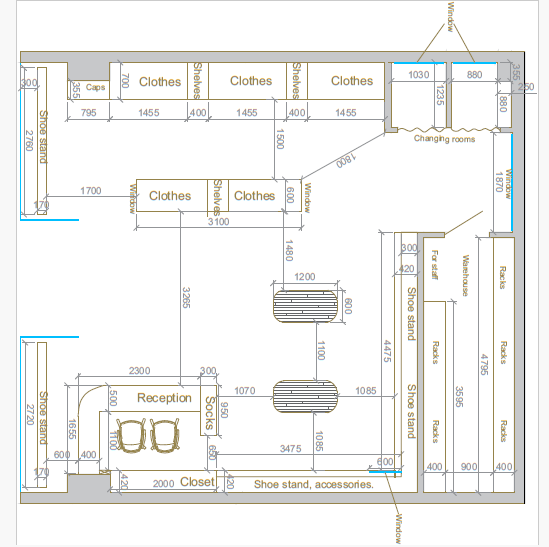

Based on these insights, we propose made three slight changes to our store layout. Here is the current layout of our store. Given the store's small size(it is not a department store or big store), we believe customers can quickly get an overview the products. However, making a purchase decision might be influenced by how the products are presented. Our recommendations are as follows:

1.	Move the changing room from one side to the other (switching with the warehouse section). This change is proposed so customers who intend to purchase outfits will also be exposed to the sneakers on their way to the changing room (the outfits + sneakers pair has a very high lift).

2.	Relocate caps to the cashier counter to increase their visibility.

3.	Add two mirrors in the central area to allow those interested only in sneakers to see our attractive outfits when they go to use the mirrors.

With these changes, we believe the revenue will increase due to the increase in customer exposure to highly positively associated categories (T-Shirts,    Trousers & Sneakers).


### Summary:



1.   The threshold of 0.15% was used to filter the itemsets, meaning only those appearing in at least 0.15% ( 7 times been purchased) of all transactions were considered frequent.

2.   (WMNS AIR JORDAN 1 LOW) with a support of 0.022662% of all transactions. This means this product is the most popular or commonly purchased item among the dataset, appearing in about 2.27% of all transactions, which has been purchased approximately 103 times.

3. Weekends shows different consumer behavior compared to weekdays, as evidenced by the analysis of frequent itemsets, (WMNS AIR JORDAN 1 LOW) reported as the top common itemset during weekdays, it shown the second common items over the weekend. Instead, (Bearbrick Blindbox series 46 by Medicom Toy) takes the lead as the most frequent item purchased during weekends.

4. The most common catogery in our store is Sneakers with support of 0.390319, which means that Sneakers been in 39.0 % of total transactions. For T-shirts it is became as the second common catogery with support of 0.24



## Clustering

### In this section, we will apply various clustering algorithms and related techniques to identify distinct customer segments present in Six Squad's loyalty program. We will use past purchase behavior to form clusters, with the metrics of succecss being cluster quality (ex: sihouette score) and interpretability of clusters (how useful they are for decision making).

### **What are the major customer segments in Six Squad's loyalty program (based on purchasing behavior)?**

#### **K-Means**

In [11]:
## CLUSTERING BY CUSTOMERS in Loyalty Program
df_customers = merged_df.groupby('CustomerID').agg({"CheckID":lambda x: x.nunique(),'StoreName':pd.Series.mode
                                                    ,'Quantity':'sum', 'Discount':'sum', 'Summ':'sum', 'Gender':pd.Series.mode,
                                                    'Brand':pd.Series.mode, 'Category':pd.Series.mode, 'Collaboration':'mean', 'DayType':pd.Series.mode, 'Price':'sum'}).reset_index()


# Converting counting values to averages

to_convert = ['Quantity', 'Discount','Summ']

for i in to_convert:
    if i == 'Discount':
        df_customers[i] = df_customers[i]/df_customers['Price']
    else:
        df_customers[i] = df_customers[i]/df_customers['CheckID']

df_customers.rename(columns= {'CheckID':'Total Transactions', 'StoreName':'MostVisitedStore', 'Quantity':'Average Quantity',
                     'Discount': "Average Discount Rate", 'Summ':'Average Cart Value', 'Gender':'PreferredProductGender',
                     'Brand':'PreferredBrand', 'Category':'PreferredCategory', 'Collaboration':'CollaborationRate', 'DayType':"PreferredDayType"}, inplace=True)

# Dropping guest transactions - 913408979892110F11ED60BAE5B67FDC

guest =  df_customers[df_customers['CustomerID'] == '913408979892110F11ED60BAE5B67FDC']
df_customers =  df_customers[df_customers['CustomerID'] != '913408979892110F11ED60BAE5B67FDC']
df_customers.drop('Price', axis=1, inplace = True) # dropping unnecessary column

display(df_customers.head())
print(f' Total Number of Loyalty Members = {df_customers.shape[0]}')

,CustomerID,Total Transactions,MostVisitedStore,Average Quantity,Average Discount Rate,Average Cart Value,PreferredProductGender,PreferredBrand,PreferredCategory,CollaborationRate,PreferredDayType
0,80E1B11BC1989B5111EE102BA71DD6C3,1,Store FORUM,12.0,0.0,494000.0,Men,Jordan,T-shirts,0.00,Weekend
1,80E1B11BC1989B5111EE102BA71DD6C8,1,Store FORUM,1.0,0.0,108000.0,Men,Jordan,Sneakers,0.00,Weekend
2,80E1B11BC1989B5111EE102BA71DD6C9,1,Store DOSTYK PLAZA,4.0,0.0,97200.0,"[Men, Unisex]",Jordan,T-shirts,0.25,Weekend
3,80E1B11BC1989B5111EE102BA71DD6CB,1,Store FORUM,1.0,0.0,91000.0,Women,Jordan,Sneakers,0.00,Weekend
4,80E1B11BC1989B5111EE102BA71DD6D1,1,Store FORUM,1.0,0.0,132000.0,Women,Nike,Sneakers,1.00,Weekday


 Total Number of Loyalty Members = 974


**There are 974 active members in Six Squad's loyalty program.**

In [12]:
# Standardizing Data
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Dropping categorical cols for KMeans
kmeans_cols = df_customers.drop(['CustomerID','MostVisitedStore','PreferredProductGender','PreferredBrand','PreferredCategory','PreferredDayType'], axis=1)

# Standardizing Data
sc = StandardScaler()
kmeans_scaled = pd.DataFrame(sc.fit_transform(kmeans_cols), columns = kmeans_cols.columns)

# Re-adding categoricals for KModes
cat_cols = df_customers[['MostVisitedStore','PreferredProductGender','PreferredBrand','PreferredCategory','PreferredDayType']].loc[:]

# For mode values, return only single mode (if multiple modes exist)
my_regex = r'^\[.*\]$'
cat_cols['MostVisitedStore'] = cat_cols.MostVisitedStore.astype('str').replace(to_replace=my_regex, value='Both', regex=True)
cat_cols['PreferredProductGender'] = cat_cols.PreferredProductGender.astype('str').replace({"['Men' 'Unisex']":'Men', "['Men' 'Women']":'Both',"['Unisex' 'Women']":"Women","['Men' 'Unisex' 'Women']":"Both"})
cat_cols['PreferredBrand'] = cat_cols.PreferredBrand.astype('str').replace(to_replace=my_regex, value='Multiple', regex=True)
cat_cols['PreferredCategory'] = cat_cols.PreferredCategory.astype('str').replace(to_replace=my_regex, value='Multiple', regex=True)
cat_cols['PreferredDayType'] = cat_cols.PreferredDayType.astype('str').replace(to_replace=my_regex, value='Both', regex=True)

nan_idx = cat_cols[cat_cols['PreferredProductGender'] == 'nan'].index # drop the single nan row
cat_cols.drop(index=nan_idx, axis=0, inplace=True)

kmeans_scaled.describe()

,Total Transactions,Average Quantity,Average Discount Rate,Average Cart Value,CollaborationRate
count,9.740000e+02,9.740000e+02,9.740000e+02,9.740000e+02,9.740000e+02
mean,4.377060e-17,-2.553285e-17,2.188530e-17,1.386069e-16,1.459020e-17
std,1.000514e+00,1.000514e+00,1.000514e+00,1.000514e+00,1.000514e+00
min,-3.946317e-01,-5.251292e-01,-2.907360e-01,-1.337602e+00,-4.390253e-01
25%,-3.946317e-01,-5.251292e-01,-2.907360e-01,-6.616237e-01,-4.390253e-01
50%,-3.946317e-01,-5.251292e-01,-2.907360e-01,-1.298630e-01,-4.390253e-01
75%,-3.946317e-01,4.637144e-01,-2.907360e-01,3.143684e-01,-4.390253e-01
max,8.275398e+00,1.035215e+01,6.213301e+00,6.969059e+00,3.165572e+00


**Mean = 0 and Standard Deviation = 1, scaling was successful.**

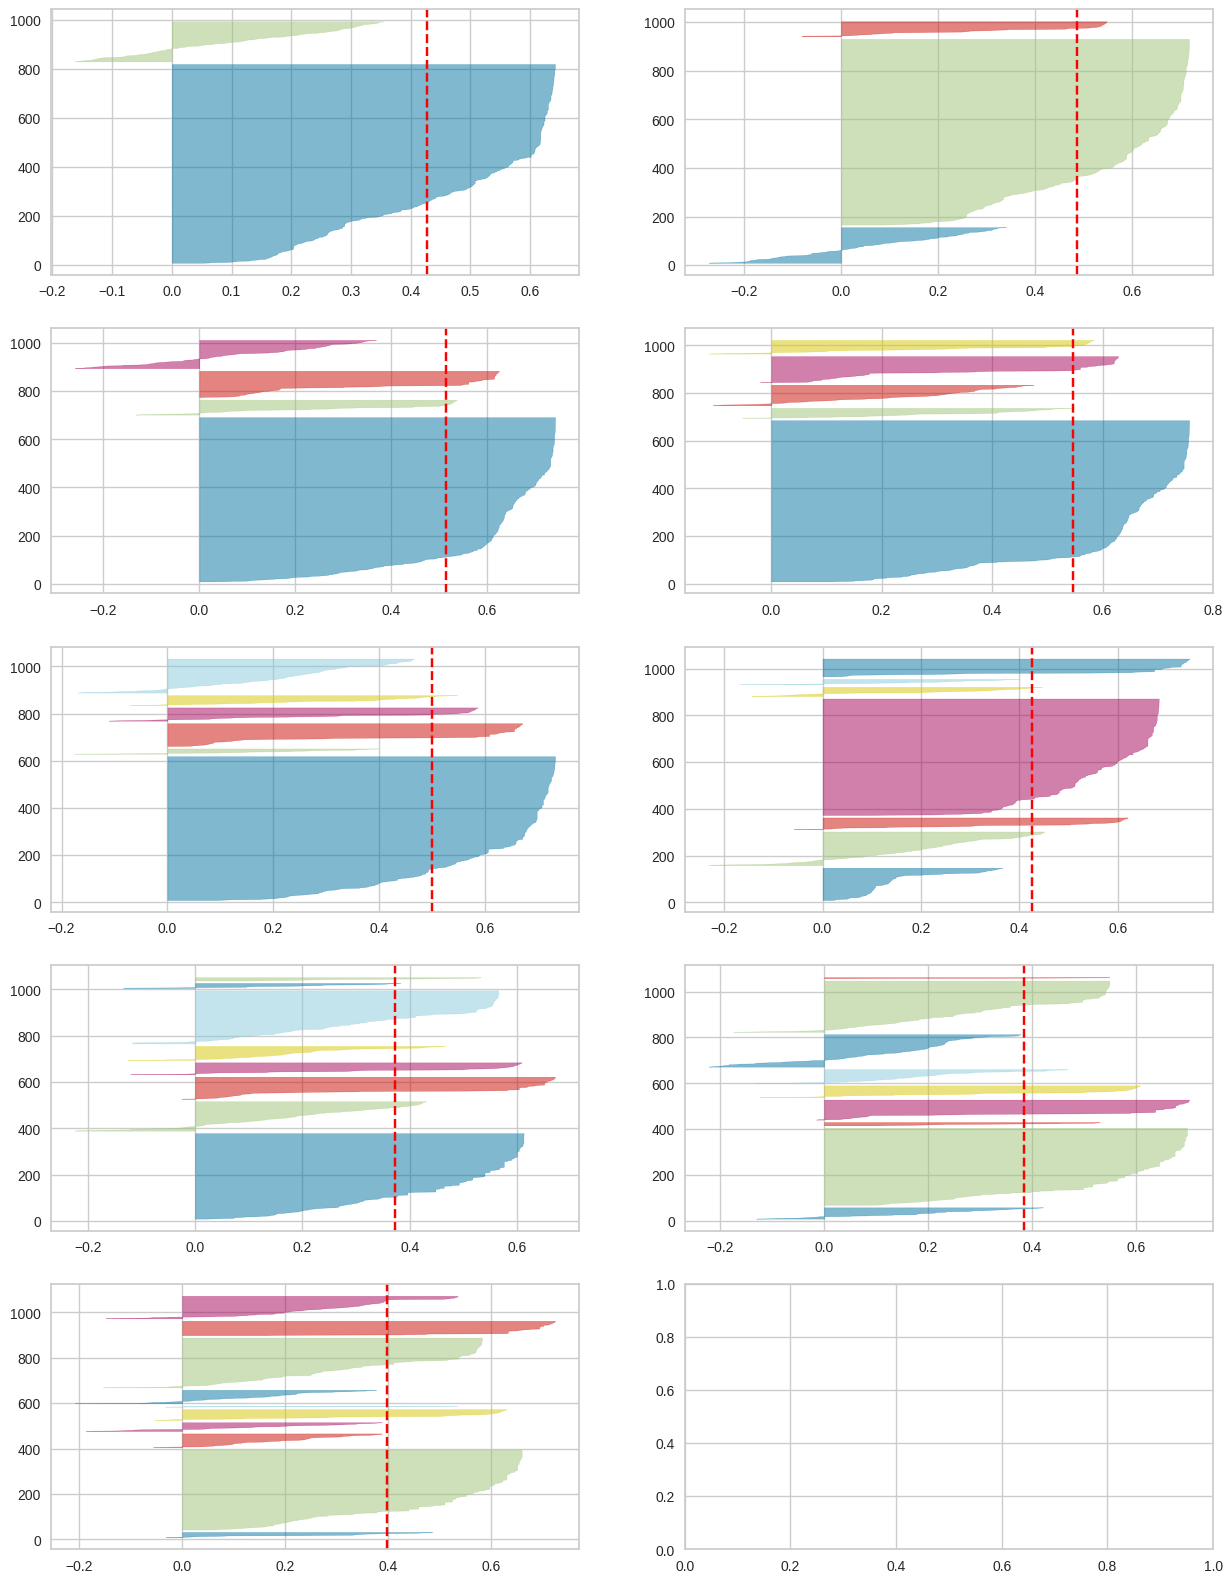

In [13]:
# Silhouette Analysis - Source - https://vitalflux.com/kmeans-silhouette-score-explained-with-python-example/

from yellowbrick.cluster import SilhouetteVisualizer
from matplotlib import pyplot as plt

n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, ax = plt.subplots(5, 2, figsize=(15,20))

for num in n_clusters:

    # Run KMeans
    kmeans = KMeans(n_clusters=num, n_init=10, random_state=0)
    q, mod = divmod(num, 2)

    # Visualize
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(kmeans_scaled)

**k=5 gives us the highest silhouette score of around 0.55, as well as relatively balanced clsuter sizes, so we will use that for our KMeans model.**

In [14]:
# Modelling
k_model = KMeans(n_clusters=5, random_state=0, n_init='auto')

kmeans_labeled = kmeans_scaled.iloc[:]
kmeans_labeled['label'] = k_model.fit(kmeans_scaled).labels_

In [15]:
# Visualizing KMeans clusters w/ PCA

import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA

pca_k = PCA(n_components=3)

pca_k_3 = pca_k.fit_transform(kmeans_scaled)
pca_k_3_df = pd.DataFrame(pca_k_3)

print(f' Top 3 PCAs expalain {pca_k.explained_variance_ratio_.sum()*100.:2f}% of variance')

px.scatter_3d(data_frame=pca_k_3_df, x=0, y=1, z=2,  color=kmeans_labeled['label'])

 Top 3 PCAs expalain 75.344584% of variance


**The Clusters are fairly separate, except for Clusters 0 & 3 that are in the corner. Those two clusters appear to be divided down the middle with no real cluster separation.**

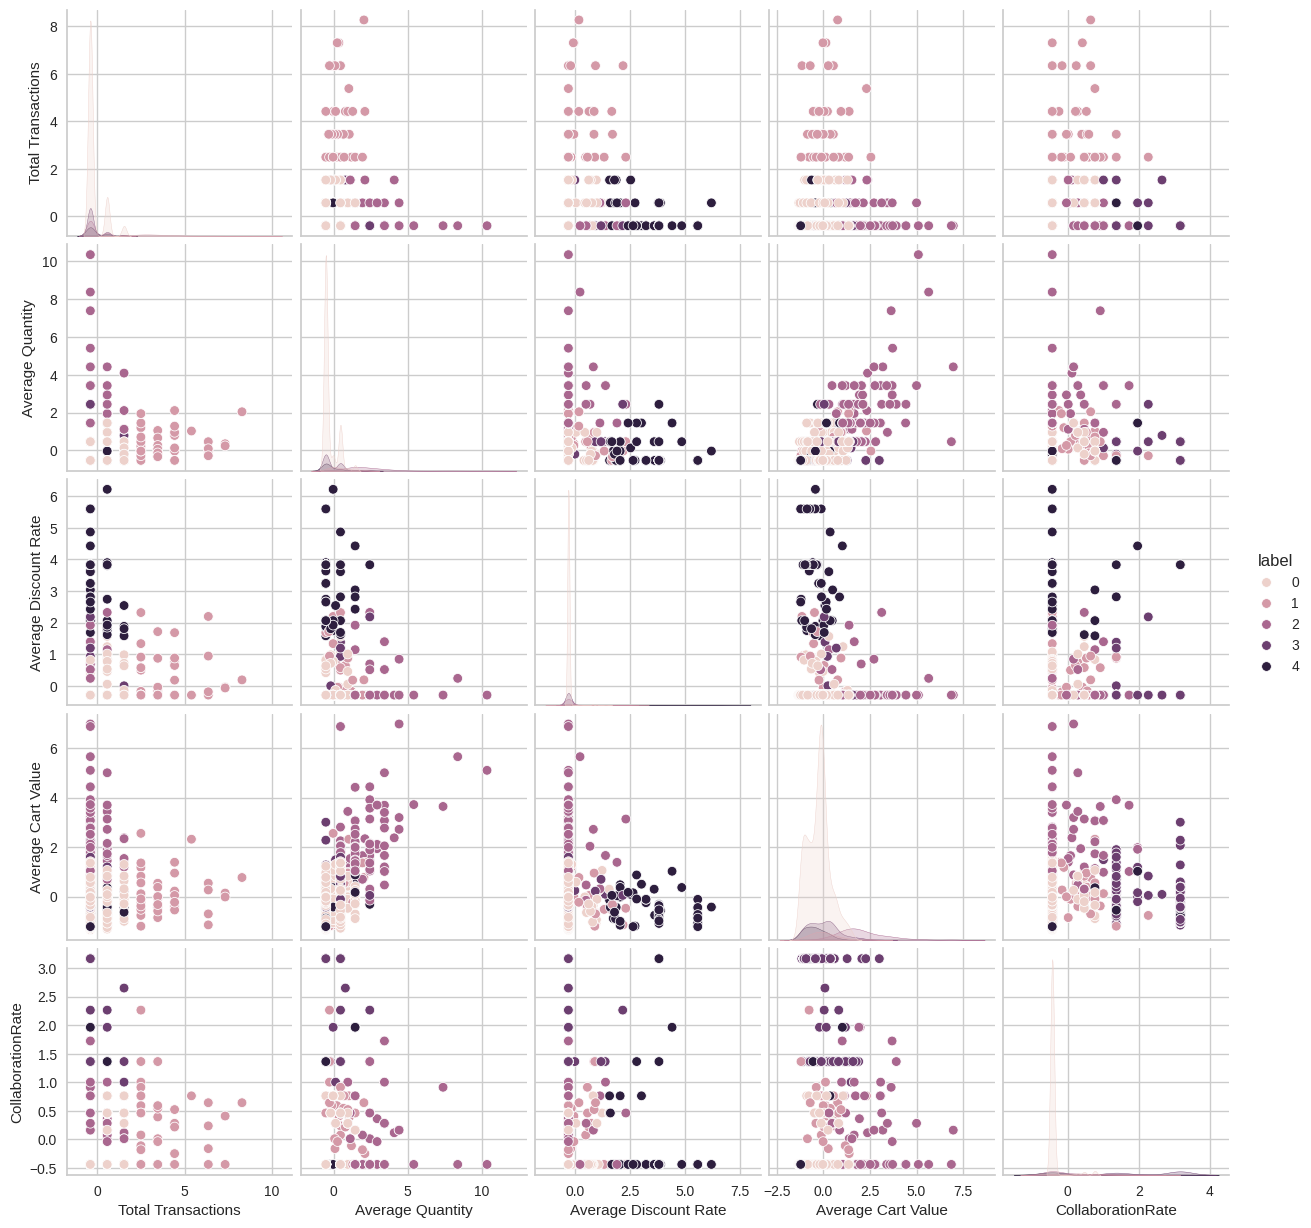

In [16]:
# Visualizing Clusters using Pair Plots
sns.pairplot(data=kmeans_labeled, hue = 'label')

**If we take a look at the distribution of each variable by cluster, Average Cart Value appears to have the most significant inter-cluster variation. Average quantity and collaboration rate also show separation between clusters, but to a much lesser extent. These three appear to be the most important when it comes to determining cluster assignment.**

In [17]:
# Creating Cluster Characteristics Table for easier analysis
k_means_characteristics = pd.DataFrame(sc.inverse_transform(kmeans_labeled.groupby('label').agg('mean').reset_index().drop('label', axis=1)), columns = kmeans_scaled.columns)
k_means_characteristics['Cluster Size'] = kmeans_labeled.groupby('label')['Total Transactions'].agg('count').reset_index()['Total Transactions']
k_means_characteristics.rename(columns={'Total Transactions':'Average Transactions (Lifetime)',	'Average Quantity':'Average QTY per Transaction',	'Average Discount Rate':'Average Discount Received (%)',
                                'CollaborationRate':'Collaborations (%)'}, inplace=True)
k_means_characteristics[['Average Discount Received (%)','Collaborations (%)']] = k_means_characteristics[['Average Discount Received (%)','Collaborations (%)']]*100
k_means_characteristics

,Average Transactions (Lifetime),Average QTY per Transaction,Average Discount Received (%),Average Cart Value,Collaborations (%),Cluster Size
0,1.224520,1.243968,0.222303,88262.643033,1.065977,677
1,5.380952,1.890788,4.450681,114442.937944,17.719201,42
2,1.287356,3.860153,1.191507,268439.504866,12.218433,87
3,1.181818,1.398485,0.552052,108228.681818,80.385281,110
4,1.310345,1.379310,32.836325,73481.824713,8.477011,58


#### **Do categorical variables improve clustering outcome?**

In [19]:
# Import Kprototypes module for clustering by Numericals + Categoricals
!pip install kmodes
from kmodes.kprototypes import KPrototypes

# Calculating optimal number of clusters

cost = []
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
kp_df = cat_cols.join(kmeans_scaled).dropna().reset_index(drop=True)
for num in n_clusters:

  test = KPrototypes(n_clusters = num, random_state=0, n_jobs = -2)
  test.fit_predict(kp_df, categorical=[0,1,2,3,4])
  cost.append(test.cost_)

# plotting Costs

px.line(x = n_clusters,y=cost, title="Cost by # of Clusters").update_layout(xaxis_title='Number of Clusters', yaxis_title="Cost")

**Like KMeans, KPrototypes cost decreases rapidly till k = 5. We will use this for our final KPrototypes model**

In [20]:
from sklearn.metrics import silhouette_score

# Modelling & Labelling
kp = KPrototypes(n_clusters =5, random_state=0, n_jobs = -2) # n_jobs (-2 uses all CPUs)
kp_labeled = kp_df.iloc[:]
kp_labeled['label'] = kp.fit_predict(kp_df, categorical=[0,1,2,3,4])

# KModes Cluster Characteristics
kp_characteristice = kp_labeled.groupby('label').agg({'MostVisitedStore':pd.Series.mode
                                                    ,'Average Quantity':'mean', 'Average Discount Rate':'mean', 'Average Cart Value':'mean', 'PreferredProductGender':pd.Series.mode,
                                                    'PreferredBrand':pd.Series.mode, 'PreferredCategory':pd.Series.mode, 'CollaborationRate':'mean', 'PreferredDayType':pd.Series.mode,
                                                               "Total Transactions":"mean", }).reset_index()
kp_characteristice['Size'] = kp_labeled.groupby('label')['MostVisitedStore'].agg('count').reset_index()['MostVisitedStore']

# Results
print(f"Silhouette Score = {silhouette_score(kp_df.iloc[:,5:], kp_labeled['label'])}")
kp_characteristice

Silhouette Score = 0.5437076189889013


,label,MostVisitedStore,Average Quantity,Average Discount Rate,Average Cart Value,PreferredProductGender,PreferredBrand,PreferredCategory,CollaborationRate,PreferredDayType,Total Transactions,Size
0,0,Store FORUM,-0.297996,-0.255407,-0.268134,Men,Jordan,Sneakers,-0.403195,Weekday,-0.175757,669
1,1,Store DOSTYK PLAZA,-0.168047,3.715253,-0.446246,Men,Jordan,Sneakers,-0.149767,Weekday,-0.144878,54
2,2,Store FORUM,-0.165692,-0.222677,-0.056709,Men,Jordan,Sneakers,2.508407,Weekday,-0.229488,105
3,3,Store FORUM,0.355721,0.233022,0.099870,Men,Jordan,Sneakers,0.199681,Weekday,3.825700,42
4,4,Store FORUM,2.052584,-0.154092,1.989910,Men,Jordan,Sneakers,0.063053,Weekend,-0.104695,103


**These clusters have a lower Silhouette Score than KMeans and the categorical variables do not add any useful information to the customer segment profiles. So, we will stick with numerical data for KMeans clustering.**

#### **Does PCA improve cluster quality?**


In [21]:
# Rerunning KMeans Clustering, but using PCA

pca_k = PCA(n_components=4)

pca_k_values = pca_k.fit_transform(kmeans_scaled)
pca_k_df = pd.DataFrame(pca_k_values)

print(f' Top 4 PCAs expalain {pca_k.explained_variance_ratio_.sum()*100.:2f}% of variance')


 Top 4 PCAs expalain 93.714832% of variance


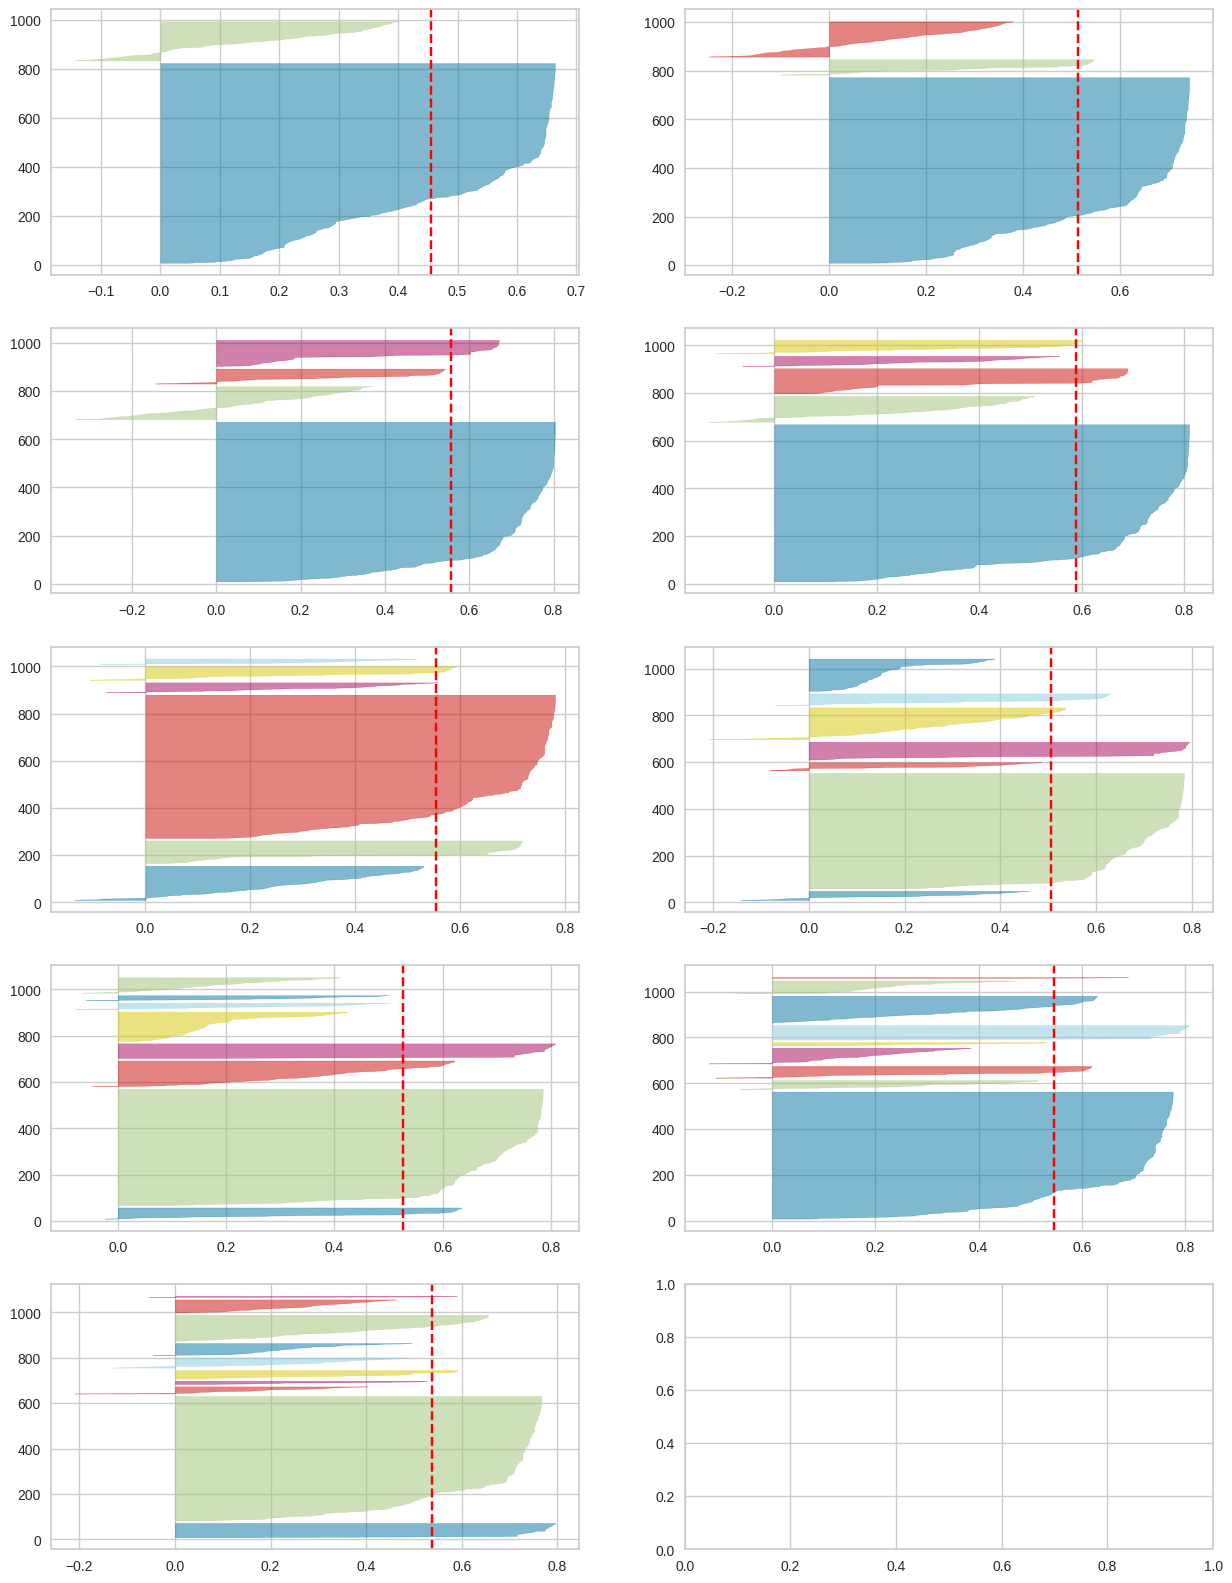

In [22]:
# Silhouette Analysis - https://vitalflux.com/kmeans-silhouette-score-explained-with-python-example/

n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, ax = plt.subplots(5, 2, figsize=(15,20))

for num in n_clusters:

    # Run KMeans
    kmeans = KMeans(n_clusters=num, n_init=10, random_state=0)
    q, mod = divmod(num, 2)

    # Visualize
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(pca_k_values)

**k = 5 is again the optimal cluster number, based on silhouette score (approx. 0.59). This is higher than the non-PCA silhouette score (approx. 0.55)**

In [23]:
# Modelling
k_model_pca = KMeans(n_clusters=5, random_state=0, n_init='auto')

kmeans_PCA_labeled = pca_k_df.iloc[:]
kmeans_PCA_labeled['label'] = k_model_pca.fit(pca_k_df).labels_

# Plotting Clusters using Top 3 PCAs
px.scatter_3d(data_frame=kmeans_PCA_labeled, x=0, y=1, z=2,  color=kmeans_PCA_labeled['label'])


**Visually speaking, the PCA-based clusters appear to be tighter, with lower intra-cluster variance and slightly greater cluser separation than the non-PCA clusters.**

In [24]:
# Creating Cluster Characteristics Table for easier analysis
PCA_real_values = pd.DataFrame(sc.inverse_transform(kmeans_scaled),columns = kmeans_scaled.columns).join(kmeans_PCA_labeled['label'])
k_means_PCA_characteristics = PCA_real_values.groupby('label').agg('mean').reset_index().drop('label', axis=1)
k_means_PCA_characteristics['Cluster Size'] = PCA_real_values.groupby('label')['Total Transactions'].agg('count').reset_index()['Total Transactions']
k_means_PCA_characteristics.rename(columns={'Total Transactions':'Average Transactions (Lifetime)',	'Average Quantity':'Average QTY per Transaction',	'Average Discount Rate':'Average Discount Received (%)',
                                'CollaborationRate':'Collaborations (%)'}, inplace=True)
k_means_PCA_characteristics[['Average Discount Received (%)','Collaborations (%)']] = k_means_PCA_characteristics[['Average Discount Received (%)','Collaborations (%)']]*100
k_means_PCA_characteristics

,Average Transactions (Lifetime),Average QTY per Transaction,Average Discount Received (%),Average Cart Value,Collaborations (%),Cluster Size
0,1.227273,1.216919,0.228001,85427.693434,0.969697,660
1,1.284404,3.518349,1.097226,254695.889205,12.550492,109
2,1.169811,1.378931,0.572884,103445.330189,81.626235,106
3,5.380952,1.890788,4.450681,114442.937944,17.719201,42
4,1.280702,1.385965,33.133131,73084.429825,8.040936,57


**Differences between PCA and non-PCA KMeans results**:
* PCA KMeans has a higher silhouette score - 0.59 vs 0.55
* PCA KMeans' clusters are slightly less balanced than non-PCA clusters. But this appears to be due to the lack of noise that led to less distinction between clusters. PCA clsuters are more likely to reflect real segment sizes in this regard.  
* The characteristics of matching clusters are slightly different. The PCA KMeans clusters are likely to be more accurate representations, owing to their higher silhouette score and less noisy datapoints.



### **KMeans Findings**: Numerical Only + PCA + (K = 5) results in the best clusterings for KMeans

#### **Interpretation of K-Means Clustering** **(K=5, w/ PCA)**

* ##### **Cluster 0**: Occasional Shoppers
  * Size = Large, Avg Transactions = Low, Avg Qty = Low, Avg Disc = Low, Avg Cart Value = Low, CollabRate = Low
  * **Value to business** = Moderate (due to size) - These are the bulk of customers who shop occasionally, and purchase relatively low cost items at full price  
  * **Marketing Strategy**: Promote new, low cost items, such as undergarments & collectibles.


* ##### **Cluster 1**: Whales
  * Size = Medium, Avg Transactions = Low, Avg Qty = High, Avg Disc = Low , Avg Cart Value = High, CollabRate = Medium
  * **Value to business** = High - These are the whales, customers that shop occasionally but spend heavily each visit.
  * **Marketing Strategy**: Attract to store via specialty luxury items. Adopt a cross-selling strategy, with product bundles identified in Market Basket Analysis.

* ##### **Cluster 2**: Collaboration Hunters
  * Size = Medium , Total Transactions = Low , Avg Qty = Low , Avg Disc = Low, Avg Cart Value = Medium , CollabRate = High
  * **Value to business** = Moderate - These customers almost exclusively purchase items that are brand collaborations, and pay full price.
  * **Marketing Strategy**: Create a new loyalty segment in which members are informed of new collabs as they drop and get limited-time exclusive access to purchase them, possibly at a premium. Adopt a celebrity and status based ad strategy (the CollabRate shows this group places relatively greater value on brand image).       

* ##### **Cluster 3**: Frequent Customers
  * Size = Low, Avg Transactions = High, Avg Qty = Medium, Avg Disc = Medium, Avg Cart Value = Medium, CollabRate = Medium
  * **Value to business** = High - These are customers that purchase medium priced items very often, at a moderate discount. A moderate preferance for collabs
  * **Marketing Strategy**: Promote moderately-priced products, with an emphasis on new stock and brand collaborations.

* ##### **Cluster 4**: Bargain Hunters
  * Size = Low, Total Transactions = Low, Avg Qty = Low, Avg Disc = High, Avg Cart Value = Low, CollabRate = Low
  * **Value to business** = Low - These are bargain hunters, only buying low cost items at a heavy discount
  * **Marketing Strategy**: Use this segment to liquidate stock that is out of fashion or has low turnover.


### **Does Hierarchical Clustering improve Cluster Quality and Interpretability?**

In [25]:
# Using PCA to remove noise and form cleaner clusters

pca_h = PCA(n_components=4)

pca_h_df = pd.DataFrame(pca_h.fit_transform(kmeans_scaled))

print(f' Top 4 PCAs expalain {pca_h.explained_variance_ratio_.sum()*100.:2f}% of variance')

 Top 4 PCAs expalain 93.714832% of variance


In [41]:
# HC with PCA

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

# Calculating optimal number of clusters

n_clusters = [3,4,5,6,7,8,9,10]
linkage_methods = ['single','complete', 'average', 'centroid', 'weighted', 'median', 'ward']
# clustering_critera = ['inconsistent', 'distance','maxclust']
scores = pd.DataFrame()
iterator = 0

# Calculating silhouette score for each linkage_method and n_clust combination
for num in n_clusters:
  for method in linkage_methods:
    Z = linkage(pca_h_df, method=method)
    cluster_labels = fcluster(Z, num, criterion='maxclust')
    scores.loc[iterator, 'n_clust'] = num
    scores.loc[iterator, 'method'] = method
#   scores['criterion'] = criterion
    scores.loc[iterator,'silhouette score'] = silhouette_score(pca_h_df, cluster_labels)
    iterator += 1

# Plotting Scores
px.scatter_3d(data_frame=scores,x = 'n_clust', y='method', z='silhouette score', title="Silhouette Scores by linkage method and n_clust - PCA").update_layout(xaxis_title='Number of Clusters', yaxis_title="Silhouette Score")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



In [27]:
# HC w/o PCA

# Calculating optimal number of clusters - NON PCA

n_clusters = [3,4,5,6,7,8,9,10]
linkage_methods = ['single','complete', 'average', 'centroid', 'weighted', 'median', 'ward']
# clustering_critera = ['inconsistent', 'distance','maxclust']
scores = pd.DataFrame()
iterator = 0

# Calculating silhouette score for each linkage_method and n_clust combination
for num in n_clusters:
  for method in linkage_methods:
    Z = linkage(kmeans_scaled, method=method)
    cluster_labels = fcluster(Z, num, criterion='maxclust')
    scores.loc[iterator, 'n_clust'] = num
    scores.loc[iterator, 'method'] = method
#   scores['criterion'] = criterion
    scores.loc[iterator,'silhouette score'] = silhouette_score(kmeans_scaled, cluster_labels)
    iterator += 1

# Plotting Scores
px.scatter_3d(data_frame=scores,x = 'n_clust', y='method', z='silhouette score', title="Silhouette Scores by linkage method and n_clust - Non-PCA").update_layout(xaxis_title='Number of Clusters', yaxis_title="Silhouette Score")

 Non-PCA clusterings are relatively higher quality at most Ks compared to PCA Clustering, so we will choose non-PCA clustering for the Hierachical method.

 K= 3 and method = weighted, generates te highest quality clusters (by Silhouette score). Note that none of the clusters are as balanced as KMeans.

In [28]:
# Modelling

Z = linkage(kmeans_scaled, method='weighted')
cluster_labels = fcluster(Z,3, criterion='maxclust')
hierarchical_labeled = kmeans_scaled.loc[:]
hierarchical_labeled['label'] = cluster_labels
print('Cluster Sizes')
hierarchical_labeled.groupby('label')['Total Transactions'].agg('count').reset_index()['Total Transactions']

Cluster Sizes


0      5
1      7
2    962
Name: Total Transactions, dtype: int64

In [29]:
# Using PCA to visualize clusters

px.scatter_3d(data_frame=pca_h_df, x=0, y=1, z=2,  color=hierarchical_labeled['label'])


#### Visually, the Hierarchical clustering singles out outliers without combining them with the average datapoints (the vast majority).


In [30]:
# Hierarchical Cluster Characteristics

hierarchical_characteristics = pd.DataFrame(sc.inverse_transform(hierarchical_labeled.groupby('label').agg('mean')), columns = kmeans_scaled.columns)
hierarchical_characteristics['Size'] = hierarchical_labeled.groupby('label')['Total Transactions'].agg('count').reset_index()['Total Transactions']
hierarchical_characteristics.rename(columns={'Total Transactions':'Average Transactions (Lifetime)',	'Average Quantity':'Average QTY per Transaction',	'Average Discount Rate':'Average Discount Received (%)',
                                'CollaborationRate':'Collaborations (%)'}, inplace=True)
hierarchical_characteristics[['Average Discount Received (%)','Collaborations (%)']] = hierarchical_characteristics[['Average Discount Received (%)','Collaborations (%)']]*100

hierarchical_characteristics

,Average Transactions (Lifetime),Average QTY per Transaction,Average Discount Received (%),Average Cart Value,Collaborations (%),Size
0,1.000000,7.800000,0.899441,535470.000000,10.833333,5
1,8.571429,1.948810,5.801250,105500.091270,15.710246,7
2,1.359667,1.495431,2.454486,104642.307531,12.160900,962


#### **Interpretation of Hierarchical Clustering**

* ##### Cluster 1 (Blue): Size = Small , Total Transactions = Medium , Avg Qty = High , Avg Disc = Low, Avg Cart Value = High , CollabRate = High
Value to business = High - These are the whales, customers that shop occasionally but spend heavily each visit.       
* ##### Cluster 2 (Pink): Size = Small, Total Transactions = High, Avg Qty = Medium, Avg Disc = Low, Avg Cart Value = Medium, CollabRate = High
Value to business = High - These are customers that regularly purchase medium priced items. A moderate preferance for collabs
* ##### Cluster 3 (Yellow): Size = High, Total Transactions = High, Avg Qty = Low, Avg Disc = Low, Avg Cart Value = Medium, CollabRate = Medium
Value to business = Moderate (due to size) - These are the average customers that purchase occasionally, pay full price and have a moderate preference for collaborations.

#### **Conclusion**: The Hierarchical clusterings are better than KMeans at highlighting outliers, but is not as effective as KMeans for subdividing the non-outlier customers.

### **Can DBSCAN help subdivide the dense non-outlier datapoints into interpretable clusters?**

DBSCAN is a clustering algorithm that is effective at clustering datapoints based on density. We will test if DBSCAN can break down the dense customers groups into meaningful sub-clusters that KMeans and Hierarchical may not be able to handle.

In [31]:
from sklearn.cluster import DBSCAN

## PCA Data

dbs = DBSCAN(eps=1.25) # select by random trial, this value provides a manageable number of clusters
dbs.fit(pca_h_df)

print(f"Silhouette Score = {silhouette_score(kmeans_scaled, dbs.labels_)}")
px.scatter_3d(data_frame=pca_h_df, x=0, y=1, z=2,  color=dbs.labels_)


Silhouette Score = 0.47666398261550996


In [32]:

## Non PCA Data

dbs = DBSCAN(eps=1.25) # select by random trial, this value provides a manageable number of clusters
dbs.fit(kmeans_scaled)

print(f"Silhouette Score = {silhouette_score(kmeans_scaled, dbs.labels_)}")
px.scatter_3d(data_frame=pca_h_df, x=0, y=1, z=2,  color=dbs.labels_)



Silhouette Score = 0.4818348721917858


Non-PCA DBSCAN is slighly higher quality than PCA DBSCAN, by silhouette score


In [33]:
# Creating Cluster Characteristics Table for easier analysis
dbs_real_values = pd.DataFrame(sc.inverse_transform(kmeans_scaled),columns = kmeans_scaled.columns).join(pd.DataFrame(dbs.labels_, columns=['label']))
dbs_characteristics = dbs_real_values.groupby('label').agg('mean').reset_index()
dbs_characteristics['Size'] = dbs_real_values.groupby('label')['Total Transactions'].agg('count').reset_index()['Total Transactions']

dbs_characteristics.rename(columns={'Total Transactions':'Average Transactions (Lifetime)',	'Average Quantity':'Average QTY per Transaction',	'Average Discount Rate':'Average Discount Received (%)',
                                'CollaborationRate':'Collaborations (%)'}, inplace=True)
dbs_characteristics[['Average Discount Received (%)','Collaborations (%)']] = dbs_characteristics[['Average Discount Received (%)','Collaborations (%)']]*100


dbs_characteristics

,label,Average Transactions (Lifetime),Average QTY per Transaction,Average Discount Received (%),Average Cart Value,Collaborations (%),Size
0,-1,3.224490,3.411492,9.994667,228608.358034,31.299638,49
1,0,1.339600,1.463670,1.540909,101689.207920,4.852223,851
2,1,1.000000,1.064516,0.000000,93320.967742,100.000000,62
3,2,1.083333,1.041667,50.439055,46377.083333,0.000000,12


**Interpretation of Clusters**

DBSCAN was able to break down the large cluster which 80% of customers fall under, into smaller sub-subclusters. The customers in these new clusters are more alike than in KMeans or Hierarchical, where they were all grouped into 1 or 2 large clusters. However, the -1 cluster, which are all the sparse datapoints deemed too noisy and unfit for any clustering, were not properly segmented (like in the case of hierarchical clustering).

Several of the dense clusters are similar in characteristics to our other clusterings, but with more granularity and precision:

* Cluster 0 is similar to the Occasional Shopper cluster in KMeans and Hierarchical
* Cluster 1 is similar to the Collaboration Hunter cluster in KMeans, however we find that these customers actually have a 100% Collaboration rate. They only buy collaborations, but this was not discovered in the other clusterings, which put the rate closer to 80% (due to them being clubbed with distant, unrelated neighbors).
* Cluster 2 is similar to the Bargain Hunter cluster in KMeans, however we find that the true discount rate for these customers is closer to 50%, not 30% as in the other clusterings.

However, the cluster with the Whales (top spenders) is not explicit here, as this outlier customer type was deemed as noise by the DBSCAN model and incorporated into cluster -1 (noisy datapoints) with all other outliers.

**Conclusions**: DBSCAN is useful at identifying subcategories in dense groups of datapoints, and has helped validate our interpretation of KMeans and Hierarchical clusterings. However, it misses out on important outlier groups that are picked up by other algorithms. Fine-tuning the algorithm may result in better results, and should be a priority in future work.   

### **Clustering Summary**

*   KMeans, Hierarchical & DBSCAN algorithms each identified clusters that represented certain kinds of customers based on their purchasing activity. Each method had its strengths and weaknesses:
  * Hierarchical - best at identifying outliers
  * DBSCAN - best at subdividing the dense customer majority group (inliers)
  * KMeans - moderate quality and precision in both tasks, but generates the most balanced clusterings with balanced performance for both inliers and outliers
  
  Each of these algorithms identified very similar kinds of customer clusters - Bargain Hunters, Big Spenders, Collaboration Hunters... - indicating these are significant and reliable customer segments that exist in Six Squad's loyalty program, making them fit for use in strategy development.
  
* These clustering insights can collectively be used to divide customers into segments, and develop personalized marketing and sales strategies based on the purchasing behaviour of each segment's customers.
* Further optimization may be done for the three methods to improve improve cluster quality and interpretability, particularly for DBSCAN.

* With so many categorical variables that we can use to subdivide our clustering, we can conduct clustering by store, gender (of product purchased), preferred Brand, Product category etc. This is a potential avenue for more in-depth, targeted clustering.





# Text Data Analysis

In [ ]:
!pip install wordcloud matplotlib
!pip install textblob
!pip install gensim
!pip install transformers torch

In [ ]:
!python -m textblob.download_corpora

In [ ]:
from google.cloud import storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, SequentialSampler
from torch.utils.data import TensorDataset
import torch
from gensim.models import LdaModel
from gensim import corpora

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

## Data Preprocessing

In [ ]:
## Reading Data

try:
# From Google Bucket
  os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/ba780-freyajiang-db0532ba95ba.json"
  client = storage.Client()
  bucket = client.get_bucket('820_group_project')

  combined_df = pd.DataFrame()
  folders = ['London', 'Tokyo', 'New York']

  for folder in folders:
      blobs = bucket.list_blobs(prefix=f'{folder}/')
      for blob in blobs:
          if blob.name.endswith('.csv'):
              blob_url = f"gs://{bucket.name}/{blob.name}"

              try:
                  df = pd.read_csv(f'gs://{bucket.name}/{blob.name}', encoding='utf-8')
              except UnicodeDecodeError:
                  try:
                      df = pd.read_csv(f'gs://{bucket.name}/{blob.name}', encoding='ISO-8859-1')
                  except UnicodeDecodeError:
                      df = pd.read_csv(f'gs://{bucket.name}/{blob.name}', encoding='cp1252')

              #Append the dataframe to the combined dataframe
              combined_df = pd.concat([combined_df, df], ignore_index=True)
except:
# Read from GitHub Repo
  combined_df = pd.read_csv(r'https://raw.githubusercontent.com/d-roho/BA820-TeamA6/main/Data%20files/combined_df_NLP.csv?token=GHSAT0AAAAAACMHWBRG7XMAIVQOUYEFDYQAZPEYYQA')

In [ ]:
combined_df

,Personal profile,Review,Number of likes,Store name,Region
0,"Local Guide Â· 490 reviews Â· 1,667 photos",The store is small and narrow making it diffic...,NaN,Foot Locker,London
1,1 review,"William was very accommodating, made the visit...",NaN,Foot Locker,London
2,1 review,lovely experience with certain workers such as...,NaN,Foot Locker,London
3,2 reviews,My recent shopping experience at your store wa...,NaN,Foot Locker,London
4,Local Guide Â· 25 reviews Â· 52 photos,Hameema very helpful with my Air Jordan 1 for ...,NaN,Foot Locker,London
...,...,...,...,...,...
13590,60 reviews ¡¤ 34 photos,Museum 911 ? observing the historical evidence...,NaN,West NYC,New York
13591,Local Guide ¡¤ 121 reviews ¡¤ 296 photos,I found neither the choice nor the convenience...,1.0,West NYC,New York
13592,Local Guide ¡¤ 95 reviews ¡¤ 554 photos,"It no longer exists, it's a new shoe brand lik...",1.0,West NYC,New York
13593,Local Guide ¡¤ 115 reviews ¡¤ 22 photos,Perfect,1.0,West NYC,New York


In [ ]:
# Check null values
combined_df.isna().sum()

Personal profile      37
Review               321
Number of likes     9471
Store name             0
Region                 0
dtype: int64

In [ ]:
# Impute missing values in 'Number of likes' and drop the remaining missing values
combined_df['Number of likes'].fillna(0, inplace=True)
combined_df.dropna(inplace=True)

In [ ]:
# Check the handling of null values
combined_df.isna().sum()

Personal profile    0
Review              0
Number of likes     0
Store name          0
Region              0
dtype: int64

In [ ]:
# Replacing unnecessary characters that are present in some languages that may not be understood by NLP packages
combined_df['Personal profile'] = combined_df['Personal profile'].str.replace('Â·', '|', regex=False)
combined_df['Personal profile'] = combined_df['Personal profile'].str.replace('¡¤', '|', regex=False)
combined_df['Review'] = combined_df['Review'].str.replace('â', '', regex=False)
combined_df['Review'] = combined_df['Review'].str.replace('ð', '', regex=False)

In [ ]:
def extract_info(profile):
    #Ensure the personal profile is string variable
    profile = str(profile)
    local_guide = 1 if 'Local Guide' in profile else 0
    reviews_match = re.search(r'(\d{1,3}(,\d{3})*\s+review(s)?)', profile)
    photos_match = re.search(r'(\d{1,3}(,\d{3})*\s+photo(s)?)', profile)
    number_reviews = int(re.sub(r'[^\d]', '', reviews_match.group(0))) if reviews_match else 0
    number_photos = int(re.sub(r'[^\d]', '', photos_match.group(0))) if photos_match else 0
    return local_guide, number_reviews, number_photos

In [ ]:
combined_df[['local_guide', 'number_review', 'number_photos']] = combined_df.apply(lambda x: extract_info(x['Personal profile']), axis=1, result_type='expand')

In [ ]:
combined_df.head()

,Personal profile,Review,Number of likes,Store name,Region,local_guide,number_review,number_photos
0,"Local Guide | 490 reviews | 1,667 photos",The store is small and narrow making it diffic...,0,Foot Locker,London,1,490,1667
1,1 review,"William was very accommodating, made the visit...",0,Foot Locker,London,0,1,0
2,1 review,lovely experience with certain workers such as...,0,Foot Locker,London,0,1,0
3,2 reviews,My recent shopping experience at your store wa...,0,Foot Locker,London,0,2,0
4,Local Guide | 25 reviews | 52 photos,Hameema very helpful with my Air Jordan 1 for ...,0,Foot Locker,London,1,25,52


In [ ]:
def clean_text(text):
    #Convert text to lowercase
    text = text.lower()
    #Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    #Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word not in stop_words]
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    return lemmatized_text

In [ ]:
combined_df['Tokenized Review'] = combined_df['Review'].apply(lambda x: clean_text(str(x)))
combined_df['Cleaned Review'] = combined_df['Tokenized Review'].apply(lambda x: ' '.join(x))

In [ ]:
combined_df

,Personal profile,Review,Number of likes,Store name,Region,local_guide,number_review,number_photos,Tokenized Review,Cleaned Review
0,"Local Guide | 490 reviews | 1,667 photos",The store is small and narrow making it diffic...,0,Foot Locker,London,1,490,1667,"[store, small, narrow, making, difficult, get,...",store small narrow making difficult get past s...
1,1 review,"William was very accommodating, made the visit...",0,Foot Locker,London,0,1,0,"[william, accommodating, made, visit, easy, ha...",william accommodating made visit easy happy he...
2,1 review,lovely experience with certain workers such as...,0,Foot Locker,London,0,1,0,"[lovely, experience, certain, worker, ahmed, h...",lovely experience certain worker ahmed helped ...
3,2 reviews,My recent shopping experience at your store wa...,0,Foot Locker,London,0,2,0,"[recent, shopping, experience, store, unfortun...",recent shopping experience store unfortunately...
4,Local Guide | 25 reviews | 52 photos,Hameema very helpful with my Air Jordan 1 for ...,0,Foot Locker,London,1,25,52,"[hameema, helpful, air, jordan, 1, brother, bi...",hameema helpful air jordan 1 brother birthday ...
...,...,...,...,...,...,...,...,...,...,...
13590,60 reviews | 34 photos,Museum 911 ? observing the historical evidence...,0,West NYC,New York,0,60,34,"[museum, 911, observing, historical, evidence,...",museum 911 observing historical evidence twin ...
13591,Local Guide | 121 reviews | 296 photos,I found neither the choice nor the convenience...,1.0,West NYC,New York,1,121,296,"[found, neither, choice, convenience, advertis...",found neither choice convenience advertised no...
13592,Local Guide | 95 reviews | 554 photos,"It no longer exists, it's a new shoe brand lik...",1.0,West NYC,New York,1,95,554,"[longer, exists, new, shoe, brand, like, eram]",longer exists new shoe brand like eram
13593,Local Guide | 115 reviews | 22 photos,Perfect,1.0,West NYC,New York,1,115,22,[perfect],perfect


Exploring this dataset, we can observe that it contains 13,595 rows, with each row containing 5 attributes: a review, the personal profile of the reviewer, the number of likes this review has received, the store the review is on, and the region of the store. Because the ‘Personal profile’ column contains multiple pieces of information, it is necessary to separate them during the pre-processing phase. Moreover, both the ‘Personal profile’ and ‘Review’ columns contain various irrelevant characters, which also requires attention during the pre-processing steps.


## Exploratory Data Analysis

| Column              | Description                                       | Dtype |
|--------------------|---------------------------------------------------|-------|
| `Personal profile`        | personal information about a reviewer                                | string|
| `Review`   | a piece of review left on a certain store                                    | string|
| `Number of likes` | number of likes a review has received                                   | int|
| `Store name`   | the name of a store a review is on | string|
| `Region`   | the region of a store | string|
| `local_guide`      | derived from `Personal profile`, this binary variable indicates whether a reviewer is a local guide or not  | int|
| `number_review`   | derived from `Personal profile`, this numerical variable indicates the total number of reviews left by a reviewer                     | int|
| `number_photos` | derived from `Personal profile`, this numerical variable indicates the total number of photos uploaded by a reviewer                     | int |
|`Cleaned Review`| a review after cleaning | string|

1. Proportion of local guides among reviewers

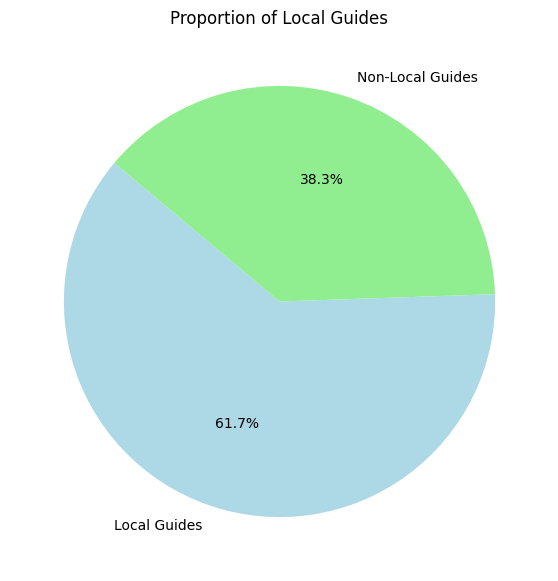

In [ ]:
local_guides_counts = combined_df['local_guide'].value_counts()
labels = 'Local Guides', 'Non-Local Guides'
colors = ['lightblue', 'lightgreen']
plt.figure(figsize=(7, 7))
plt.pie(local_guides_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Local Guides')
plt.show()

#### Two-thirds of sneaker store reviews are left by local guides (locals active on Google Maps), while the rest are written by non-local guides (visitors to the city or locals not active on Maps).   

2. Number of reviews per store

/tmp/ipykernel_7051/1837633269.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Number of Reviews', y='Store name', data=reviews_count_df, palette="viridis")


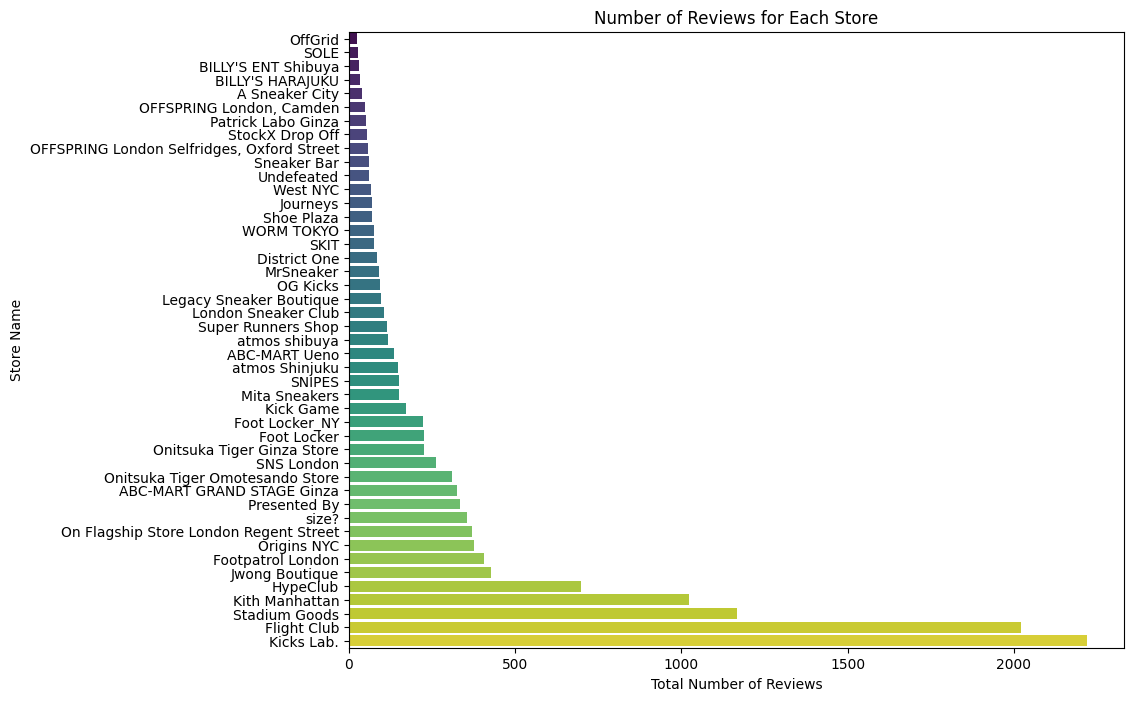

In [ ]:
reviews_count_per_store = combined_df['Store name'].value_counts()
reviews_count_df = reviews_count_per_store.reset_index()
reviews_count_df.columns = ['Store name', 'Number of Reviews']

#Sort the dataframe by the number of reviews
reviews_count_df = reviews_count_df.sort_values(by='Number of Reviews', ascending=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='Number of Reviews', y='Store name', data=reviews_count_df, palette="viridis")
plt.title('Number of Reviews for Each Store')
plt.xlabel('Total Number of Reviews')
plt.ylabel('Store Name')
plt.show()

#### Over 50% of all reviews are from just the top 5 most reviewed stores - 1 from Tokyo and London each, and 3 from NYC.

## Word Cloud for all the reviews

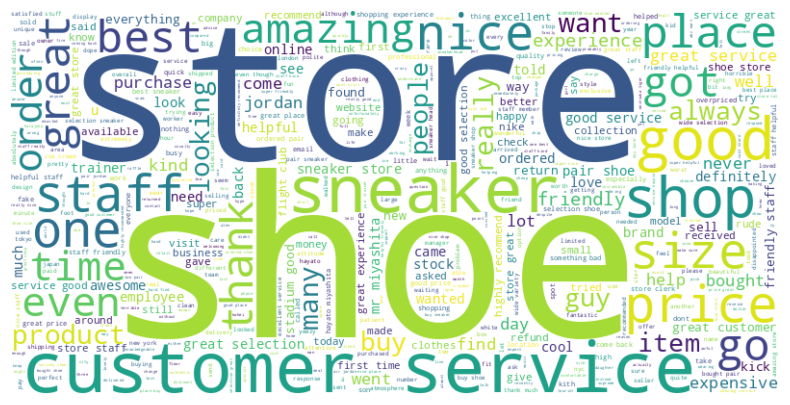

In [ ]:
text = " ".join(review for review in combined_df['Cleaned Review'].dropna() if review != "nan")
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', width=800, height=400).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Naturally 'shoe' and 'store' are the most popular words used. Beyond these terms, 'Customer Service', 'experience', 'price', and 'staff' appear frequently, indicating that they are important to customers.

In [ ]:
#Calculate a naive sentiment socre using the internal pre-trained model contained in the TextBlob package
def analyze_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity
combined_df['sentiment_polarity'], combined_df['sentiment_subjectivity'] = zip(*combined_df['Cleaned Review'].apply(analyze_sentiment))

In [ ]:
print(combined_df[['Cleaned Review', 'sentiment_polarity', 'sentiment_subjectivity']].head())

                                      Cleaned Review  sentiment_polarity  \
0  store small narrow making difficult get past s...           -0.228571   
1  william accommodating made visit easy happy he...            0.558333   
2  lovely experience certain worker ahmed helped ...            0.320000   
3  recent shopping experience store unfortunately...            0.043750   
4  hameema helpful air jordan 1 brother birthday ...            0.000000   

   sentiment_subjectivity  
0                0.564286  
1                0.708333  
2                0.491429  
3                0.556250  
4                0.000000  


## Distribution of Sentiment Polarity Score

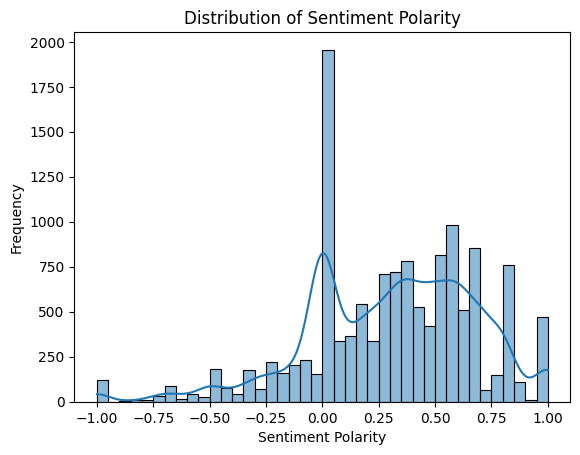

In [ ]:
sns.histplot(combined_df['sentiment_polarity'], kde=True)
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

### We can see that a majority of the reviews have either neutral or positive sentiment. This is to be expected, considering we are analysing the top sneaker stores in the world, which will naturally provide a good customer experience.

##Pick up aspects using Latent Dirichlet Allocation

In [ ]:
!pip install pyLDAvis

In [ ]:
dictionary = corpora.Dictionary(combined_df['Tokenized Review'])
corpus = [dictionary.doc2bow(doc) for doc in combined_df['Tokenized Review']]

#### Here we apply TF-IDF to vectorize the corpus and use the LDA (Latent Dirichlet Allocation) algorithm for topic modeling. LDA tries to figure out which topics exist in the reviews and which words are associated with those topics. It also determines which topics are present in each review and to what extent. What's more, we don't just look for topics once, we also try different numbers of topics, ranging from 1 to 10. For each number of topics, it calculates a "coherence score," which is a measure of how sensible the topics are (i.e., whether the words in a topic seem to belong together).

In [ ]:
##Apply TF-IDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

##Initialize variables for coherence values
coherence_values = []
model_list = []
for num_topics in range(1, 6):  #try 1 to 5 topics
    lda_model = LdaModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=5, alpha='auto', eta='auto')
    model_list.append(lda_model)
    coherencemodel = CoherenceModel(model=lda_model, texts=combined_df['Tokenized Review'], dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

##Choose the model with the highest coherence score
##reference: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
max_coherence_val = max(coherence_values)
optimal_model_index = coherence_values.index(max_coherence_val)
optimal_model = model_list[optimal_model_index]

# Print the optimal number of topics and its coherence score
print(f'Optimal Number of Topics: {optimal_model.num_topics}, Coherence Score: {max_coherence_val}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Optimal Number of Topics: 4, Coherence Score: 0.5960527934700507


In [ ]:
for num_topics in range(1, 6):
  lda_model = LdaModel(corpus, num_topics, id2word=dictionary, passes=5)
  print(f'Number of Topics: {num_topics}')
  for idx, topic in lda_model.print_topics():
    print(f'Topic {idx + 1}: {topic}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of Topics: 1
Topic 1: 0.023*"shoe" + 0.020*"store" + 0.018*"great" + 0.016*"service" + 0.016*"sneaker" + 0.015*"good" + 0.011*"customer" + 0.011*"staff" + 0.009*"price" + 0.008*"pair"
Number of Topics: 2
Topic 1: 0.033*"store" + 0.029*"sneaker" + 0.027*"shoe" + 0.020*"great" + 0.017*"price" + 0.016*"staff" + 0.016*"good" + 0.015*"place" + 0.013*"selection" + 0.010*"nice"
Topic 2: 0.032*"service" + 0.022*"customer" + 0.019*"shoe" + 0.015*"great" + 0.014*"order" + 0.014*"good" + 0.011*"pair" + 0.010*"time" + 0.010*"experience" + 0.010*"day"
Number of Topics: 3
Topic 1: 0.053*"great" + 0.037*"good" + 0.033*"sneaker" + 0.033*"store" + 0.027*"service" + 0.024*"shoe" + 0.022*"price" + 0.020*"selection" + 0.020*"place" + 0.015*"staff"
Topic 2: 0.028*"staff" + 0.027*"store" + 0.018*"nice" + 0.017*"shoe" + 0.017*"service" + 0.015*"customer" + 0.014*"helpful" + 0.010*"thank" + 0.008*"friendly" + 0.008*"kind"
Topic 3: 0.026*"shoe" + 0.016*"pair" + 0.015*"order" + 0.010*"day" + 0.010*"order

#### From the results above, when the Number of Topics = 5, we can see 5 topics and they can be seen as 5 documents linearly combined by several words with their weight. For example, we can see that in the first topic, the word 'customer' and 'service' has a relatively large coefficient; and in the second topic, we also find price is an important indicator. So far, we could retrieved key words from the topics given by LDA, such as price and service; however, there might be potential indicators that could have influence on the customer satisfaction and it couldn't be identified by the LDA algorithm. So, we manually specify some aspects like refund (refund policy), quality, brand (brand diversity) and product as aspects to do ASBA

## Aspect-Based Sentiment Analysis

###We used a pre-trained model, bert-base-uncased, provided on Hugging Face, to calculate aspect-based sentiment score for each review and for each aspect, and then we calculate each store's sentiment score by averaging the sentiment scores for the review belongs to that specific store.

In [ ]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def preprocess_for_bert(data, max_len):
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,
            max_length=max_len,             ##Max length to truncate/pad
            pad_to_max_length=True,         ##Pad sentence to max length
            return_attention_mask=True      ##Return attention mask
        )

        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    ##Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

max_len = 256
cleaned_reviews = combined_df['Cleaned Review'].tolist()
input_ids, attention_masks = preprocess_for_bert(cleaned_reviews, max_len)

In [ ]:
##Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = model.to(device)
batch = tuple(t.to(device) for t in batch)

In [ ]:
batch_size = 32

##Create the DataLoader
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

model.eval()

predictions = []
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)

In [ ]:
from scipy.special import softmax
from collections import defaultdict

In [ ]:
##Convert logits to probabilities
probabilities = [softmax(logit, axis=1) for logit in predictions]
probabilities = np.vstack(probabilities)

##Determine the sentiment class for each review
##The model is trained for binary classification (positive & negative)
sentiment_classes = np.argmax(probabilities, axis=1)

In [ ]:
def find_aspects_in_review(review, aspects):
    mentioned_aspects = {}
    for aspect in aspects:
        if aspect in review.lower():
            mentioned_aspects[aspect] = True
    return mentioned_aspects

##Self-defined aspects
aspects = ['service', 'product', 'brand', 'refund', 'price', 'quality']

aspect_mentions = [find_aspects_in_review(review, aspects) for review in cleaned_reviews]

##Associate sentiments with self-defined aspects
aspect_sentiments = []
for i, review_aspects in enumerate(aspect_mentions):
    review_sentiment = {}
    for aspect in review_aspects:
        if review_aspects[aspect]:
            review_sentiment[aspect] = 'Positive' if sentiment_classes[i] == 1 else 'Negative'
    aspect_sentiments.append(review_sentiment)

In [ ]:
aspect_sentiment_counts = defaultdict(lambda: defaultdict(int))

##Aggregate sentiments for each aspect
for review_sentiment in aspect_sentiments:
    for aspect, sentiment in review_sentiment.items():
        aspect_sentiment_counts[aspect][sentiment] += 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


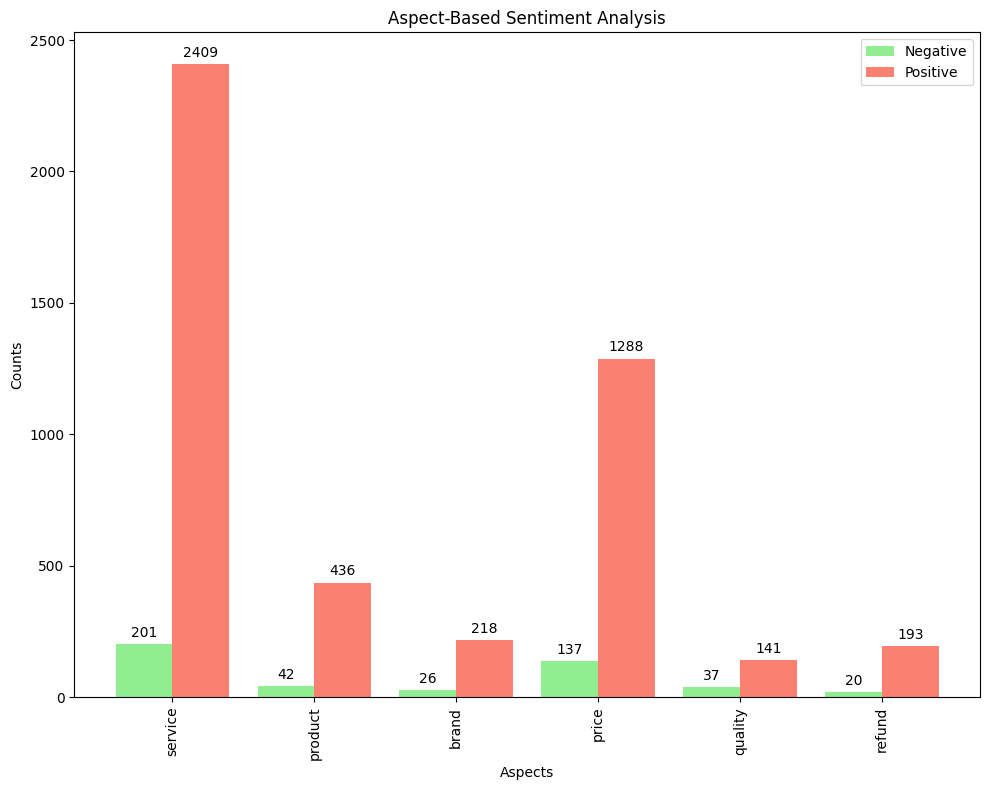

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

##Plot the sentiment counts for each aspect
aspects = list(aspect_sentiment_counts.keys())
positive_counts = [aspect_sentiment_counts[aspect]['Positive'] for aspect in aspects]
negative_counts = [aspect_sentiment_counts[aspect]['Negative'] for aspect in aspects]

x = np.arange(len(aspects))

fig, ax = plt.subplots(figsize=(10, 8))
width = 0.4
rects1 = ax.bar(x - width/2, positive_counts, width, label='Negative', color='lightgreen')
rects2 = ax.bar(x + width/2, negative_counts, width, label='Positive', color='salmon')
ax.set_xlabel('Aspects')
ax.set_ylabel('Counts')
ax.set_title('Aspect-Based Sentiment Analysis')
ax.set_xticks(x)
ax.set_xticklabels(aspects, rotation='vertical')
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

###From the visualizations above, we could see that large proportion of reviews (group by aspects) are positive reviews, which is somehow aligned with the results calculated from TextBlob in the EDA session.


In [ ]:
combined_df.reset_index(drop=True, inplace=True)

In [ ]:
for i, row in combined_df.iterrows():
    aspect_sentiments[i]['Store name'] = row['Store name']

In [ ]:
from collections import defaultdict

##Initialize a dictionary to aggregate the data
store_aspect_sentiment = defaultdict(lambda: defaultdict(list))

for review in aspect_sentiments:
    store_name = review.pop('Store name', None)
    if store_name:
        for aspect, sentiment in review.items():
            sentiment_score = 1 if sentiment == 'Positive' else 0
            store_aspect_sentiment[store_name][aspect].append(sentiment_score)
            ##The structure is {store_name: {aspect: [sentiment_scores]}}

In [ ]:
average_sentiment_by_store = {}

for store, aspects in store_aspect_sentiment.items():
    average_sentiment_by_store[store] = {}
    for aspect, scores in aspects.items():
        ##Compute average sentiment score for each aspect
        average_score = sum(scores) / len(scores)
        average_sentiment_by_store[store][aspect] = average_score

##average_sentiment_by_store: contains the average sentiment score for each aspect within each store

###We map each store to its sentiments across 6 aspects and calculate average scores to quantitatively gauge sentiment.

In [ ]:
for store, aspects in average_sentiment_by_store.items():
    print(f"Store: {store}")
    for aspect, avg_score in aspects.items():
        avg_score
        sentiment = "Positive" if avg_score >= 0.5 else "Negative"
        print(f" - Aspect: {aspect}, Average Sentiment: {sentiment} ({avg_score:.2f})")
    print("\n")

Store: Foot Locker
 - Aspect: service, Average Sentiment: Positive (0.95)
 - Aspect: product, Average Sentiment: Positive (1.00)
 - Aspect: brand, Average Sentiment: Positive (1.00)
 - Aspect: price, Average Sentiment: Positive (0.87)
 - Aspect: quality, Average Sentiment: Positive (1.00)


Store: Footpatrol London
 - Aspect: service, Average Sentiment: Positive (0.96)
 - Aspect: product, Average Sentiment: Positive (1.00)
 - Aspect: price, Average Sentiment: Positive (0.92)
 - Aspect: refund, Average Sentiment: Positive (0.96)
 - Aspect: brand, Average Sentiment: Negative (0.33)
 - Aspect: quality, Average Sentiment: Positive (1.00)


Store: Kick Game
 - Aspect: price, Average Sentiment: Positive (0.83)
 - Aspect: brand, Average Sentiment: Positive (1.00)
 - Aspect: refund, Average Sentiment: Positive (0.89)
 - Aspect: service, Average Sentiment: Positive (0.89)
 - Aspect: product, Average Sentiment: Positive (1.00)
 - Aspect: quality, Average Sentiment: Positive (0.75)


Store: Londo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###Following the aggregation, the code ranks stores within each aspect based on their sentiment scores, excluding perfect scores (=1) to mitigate bias from sparse data. We identify and list the top 3 stores for each aspect, which can serve as a recommendation for SixSquad to do shadowing. This can lead to continuous improvement for SixSquad and provides a method to pinpoint focus areas for enhancing customer satisfaction and business strategy.

In [ ]:
top_3_stores_by_aspect = defaultdict(list)

##Iterate through each store and its aspects
for store, aspects in average_sentiment_by_store.items():
    for aspect, avg_score in aspects.items():
        ##Only include modified scores less than 1.00
        if avg_score < 1.00:
            top_3_stores_by_aspect[aspect].append((store, modified_avg_score))

##Sort and select the top 3 for each aspect
for aspect, scores in top_3_stores_by_aspect.items():
    ##Sort in descending order
    scores.sort(key=lambda x: x[1], reverse=True)
    top_3_stores_by_aspect[aspect] = scores[:3]

for aspect, stores in top_3_stores_by_aspect.items():
    print(f"Aspect: {aspect}")
    for rank, (store, avg_score) in enumerate(stores, start=1):
        print(f"  {rank}. Store: {store}, Average Sentiment Score: {avg_score:.2f}")
    print("\n")

Aspect: service
  1. Store: Footpatrol London, Average Sentiment Score: 0.96
  2. Store: Legacy Sneaker Boutique, Average Sentiment Score: 0.96
  3. Store: On Flagship Store London Regent Street, Average Sentiment Score: 0.96


Aspect: price
  1. Store: District One, Average Sentiment Score: 0.97
  2. Store: Origins NYC, Average Sentiment Score: 0.94
  3. Store: Presented By, Average Sentiment Score: 0.93


Aspect: refund
  1. Store: Stadium Goods, Average Sentiment Score: 0.97
  2. Store: Footpatrol London, Average Sentiment Score: 0.96
  3. Store: Flight Club, Average Sentiment Score: 0.92


Aspect: brand
  1. Store: On Flagship Store London Regent Street, Average Sentiment Score: 0.96
  2. Store: Kith Manhattan, Average Sentiment Score: 0.92
  3. Store: Stadium Goods, Average Sentiment Score: 0.92


Aspect: quality
  1. Store: On Flagship Store London Regent Street, Average Sentiment Score: 0.93
  2. Store: HypeClub, Average Sentiment Score: 0.88
  3. Store: size?, Average Sentiment

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Summary:

We scraped reviews from 45 sneaker stores in pop culture trendsetting cities to pinpoint key aspects making them trendy. Using TextBlob for an initial polarity overview, we ensured an ample number of positive or neutral reviews. Employing Latent Dirichlet Allocation (LDA) for topic modeling, we identified topics and associated words with weights. BERT-base-uncased model processed LDA’s crucial words and our researched terms, yielding sentiment scores for each comment. We calculated average sentiment scores at the store level and listed the top 3 stores per aspect, providing valuable recommendations for Six Squad shadowing.
